# Análisis de Conversaciones Conecta 2.0

**Objetivo**: Evaluar el desempeño del asistente virtual Conecta analizando patrones de respuesta, factores que generan respuestas nulas, y comportamiento de usuarios.

**Período analizado**: Septiembre - Octubre 2025

---

## 1. LIBRERÍAS

In [39]:
import os
import json
import time
import pandas as pd
# from google.oauth2 import service_account
# from google.cloud import aiplatform
# from google.api_core import exceptions
# from vertexai.generative_models import GenerativeModel, GenerationConfig
# Importamos solo lo que está disponible en tu versión de SDK

In [40]:
import re
import io
import csv
import numpy as np
from tqdm import tqdm
import zipfile

from dotenv import load_dotenv

# Data Science & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
from wordcloud import WordCloud

# Deep Learning & Generative AI
# import torch
# import tensorflow as tf
# import transformers
# import openai
import google.generativeai as genai
from google import genai as google_genai
from google.genai import types

# NLP
# import nltk
# import spacy

# Data Handling
# import openpyxl
# from sqlalchemy import create_engine

# APIs & Auth
from googleapiclient.discovery import build

# Other utilities
import requests
from tenacity import retry
from google.cloud import bigquery

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

---

## 2. CARGA DE DATOS

Cargamos las conversaciones de Conecta+ desde archivos históricos y el ZIP más reciente del sistema.

#### CONECTA+

In [41]:
RUTA_HISTORICO = "../Resultados_Historicos/df_resultados.csv"
conecta_2_evaluados = pd.read_csv(RUTA_HISTORICO, sep=',')

conecta_2_evaluados.conversation_id = conecta_2_evaluados.conversation_id.astype(int)

In [42]:
def parse_csv_with_multiline_fields(file_path):
    """
    Parse CSV file that has newlines within quoted fields.
    Handles CSV-escaped quotes (doubled quotes: "").
    
    Uses a character-by-character state machine approach:
    - Tracks quote state to know when we're inside/outside quoted fields
    - Handles escaped quotes ("" becomes ")
    - Accumulates lines until complete record is found
    """
    records = []
    current_record = []
    current_field = []
    in_quotes = False
    header = None
    prev_char = ''

    with open(file_path, 'r', encoding='utf-8') as f:
        char_iter = iter(lambda: f.read(1), '')

        for char in char_iter:
            if char == '"':
                # Check if this is an escaped quote (doubled: "")
                if prev_char == '"' and in_quotes:
                    # This is an escaped quote - add one quote to field
                    current_field.append('"')
                    prev_char = ''  # Reset to avoid triple-quote issues
                    continue
                else:
                    # Toggle quote state
                    in_quotes = not in_quotes
                    prev_char = char
                    continue

            if not in_quotes:
                if char == ',':
                    # End of field
                    current_record.append(''.join(current_field))
                    current_field = []
                elif char == '\n':
                    # End of record
                    if current_field or current_record:
                        current_record.append(''.join(current_field))
                        current_field = []

                        if header is None:
                            header = current_record
                        else:
                            if len(current_record) == len(header):
                                records.append(current_record)
                        current_record = []
                else:
                    current_field.append(char)
            else:
                # Inside quotes - add everything including newlines
                current_field.append(char)

            prev_char = char

        # Handle last field/record
        if current_field or current_record:
            current_record.append(''.join(current_field))
            if len(current_record) == len(header):
                records.append(current_record)

    df = pd.DataFrame(records, columns=header)
    return df

In [43]:
# --- Constantes ---
ARCHIVOS_OBJETIVO = [
    'tbl_conversaciones_conecta2.csv',
    'tbl_encuesta_chat_ia_conecta2.csv',
    'tbl_preguntas_conversacion_conecta2.csv'
]

# --- FUNCIÓN DE CARGA MEJORADA PARA MANEJAR RESPUESTAS CON NEWLINES ---
def parse_preguntas_csv_from_zip(zip_ref, filename='tbl_preguntas_conversacion_conecta2.csv'):
    """
    Hybrid approach: Use csv.reader (handles most quotes correctly) then merge continuation rows.
    
    Some rows have improperly quoted multiline fields that csv.reader splits incorrectly.
    We detect these by checking if a row starts with valid numeric ID+FK.
    """
    with zip_ref.open(filename, 'r') as f:
        text_stream = io.TextIOWrapper(f, encoding='utf-8', errors='replace')
        reader = csv.reader(text_stream)
        raw_rows = list(reader)
    
    header = raw_rows[0]
    expected_cols = len(header)
    
    # Merge fragmented rows
    reconstructed_rows = []
    current_row = None
    
    for i, row in enumerate(raw_rows[1:], 1):
        # Check if this is the start of a new valid record
        is_new_record = False
        
        if len(row) >= 2:
            try:
                int(row[0])  # Valid ID
                int(row[1])  # Valid FK
                is_new_record = True
            except ValueError:
                is_new_record = False
        
        if is_new_record:
            # Save previous row if exists
            if current_row is not None:
                reconstructed_rows.append(current_row)
            current_row = row[:]
        else:
            # Continuation row - merge into last field of current row
            if current_row is not None and len(row) > 0:
                if len(current_row) > 0:
                    # Join the continuation data with newline
                    current_row[-1] += '\n' + ','.join(row)
    
    # Don't forget the last row
    if current_row is not None:
        reconstructed_rows.append(current_row)
    
    # Post-process: ensure all rows have exactly expected_cols columns
    final_rows = []
    for row in reconstructed_rows:
        # Handle rows that were split incorrectly by csv.reader
        # Expected structure: [ID, FK, pregunta, respuesta, calificacion, comentario]
        
        if len(row) == 4:
            # [ID, FK, pregunta, respuesta_with_maybe_calificacion_comentario]
            # Check if last column contains ",Mal/Bien/NULL at the end
            last_col = row[3]
            if '",Mal' in last_col or '",Bien' in last_col or '",NULL' in last_col:
                # Split out calificacion and comentario
                if '",Mal,' in last_col:
                    parts = last_col.rsplit('",Mal,', 1)
                    row = row[:3] + [parts[0] + '"', 'Mal', parts[1]]
                elif '",Mal' in last_col and last_col.endswith('",Mal'):
                    parts = last_col.rsplit('",Mal', 1)
                    row = row[:3] + [parts[0] + '"', 'Mal', '']
                elif '",Bien,' in last_col:
                    parts = last_col.rsplit('",Bien,', 1)
                    row = row[:3] + [parts[0] + '"', 'Bien', parts[1]]
                elif '",Bien' in last_col and last_col.endswith('",Bien'):
                    parts = last_col.rsplit('",Bien', 1)
                    row = row[:3] + [parts[0] + '"', 'Bien', '']
                elif '",NULL,' in last_col:
                    parts = last_col.rsplit('",NULL,', 1)
                    row = row[:3] + [parts[0] + '"', '', parts[1]]
                elif '",NULL' in last_col and last_col.endswith('",NULL'):
                    parts = last_col.rsplit('",NULL', 1)
                    row = row[:3] + [parts[0] + '"', '', '']
                else:
                    row = row + ['', '']
            else:
                row = row + ['', '']
        
        elif len(row) == 5:
            # [ID, FK, pregunta, partial_respuesta, more_respuesta_with_maybe_calificacion_comentario]
            # Check if last column contains ",Mal/Bien/NULL
            last_col = row[4]
            if '",Mal' in last_col or '",Bien' in last_col or '",NULL' in last_col:
                # Split out calificacion and comentario
                if '",Mal,' in last_col:
                    parts = last_col.rsplit('",Mal,', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Mal', parts[1]]
                elif '",Mal' in last_col and last_col.endswith('",Mal'):
                    parts = last_col.rsplit('",Mal', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Mal', '']
                elif '",Bien,' in last_col:
                    parts = last_col.rsplit('",Bien,', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Bien', parts[1]]
                elif '",Bien' in last_col and last_col.endswith('",Bien'):
                    parts = last_col.rsplit('",Bien', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Bien', '']
                elif '",NULL,' in last_col:
                    parts = last_col.rsplit('",NULL,', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, '', parts[1]]
                elif '",NULL' in last_col and last_col.endswith('",NULL'):
                    parts = last_col.rsplit('",NULL', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, '', '']
                else:
                    # Merge columns 3 and 4 into respuesta
                    merged_respuesta = row[3] + row[4]
                    row = row[:3] + [merged_respuesta, '', '']
            else:
                # Merge columns 3 and 4 into respuesta
                merged_respuesta = row[3] + row[4]
                row = row[:3] + [merged_respuesta, '', '']
        
        elif len(row) < expected_cols:
            # Pad with empty strings for any other case
            row = row + [''] * (expected_cols - len(row))
        
        elif len(row) > expected_cols:
            # Too many columns - merge extras into respuesta (index 3)
            num_extra = len(row) - expected_cols
            respuesta_parts = row[3:3+num_extra+1]
            merged_respuesta = ','.join(respuesta_parts)
            row = row[:3] + [merged_respuesta] + row[3+num_extra+1:]
        
        final_rows.append(row[:expected_cols])
    
    # Create DataFrame
    df = pd.DataFrame(final_rows, columns=header)
    df = df.replace('NULL', pd.NA)
    df = df.replace('', pd.NA)
    df['id_tbl_preguntas_conversacion_conecta2'] = pd.to_numeric(df['id_tbl_preguntas_conversacion_conecta2'], errors='coerce')
    df['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(df['fk_tbl_conversaciones_conecta2'], errors='coerce')
    
    return df

def cargar_dataframes_zip(zip_path, archivos_objetivo):
    """
    Carga DataFrames desde ZIP con manejo especial para tbl_preguntas_conversacion_conecta2.csv
    que contiene newlines sin escapar en el campo respuesta.
    """
    dataframes = {}
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for archivo_base in archivos_objetivo:
            archivo_encontrado = next((f for f in zip_ref.namelist() 
                                      if f.startswith(archivo_base.replace('.csv', ''))), None)
            
            if not archivo_encontrado:
                print(f"Advertencia: No se encontró '{archivo_base}'. DataFrame vacío.")
                dataframes[archivo_base] = pd.DataFrame()
                continue
            
            print(f"Procesando: '{archivo_encontrado}'...")
            
            try:
                # Special handling for preguntas file
                if 'preguntas_conversacion' in archivo_base:
                    df = parse_preguntas_csv_from_zip(zip_ref, archivo_encontrado)
                    print(f"  ✓ Cargadas {len(df):,} filas con {df['fk_tbl_conversaciones_conecta2'].nunique():,} conversaciones únicas")
                else:
                    # Standard CSV reading for other files
                    with zip_ref.open(archivo_encontrado, 'r') as f:
                        text_stream = io.TextIOWrapper(f, encoding='utf-8', errors='replace')
                        df = pd.read_csv(text_stream)
                        df = df.replace('NULL', pd.NA)
                        print(f"  ✓ Cargadas {len(df):,} filas")
                
                dataframes[archivo_base] = df
                
            except Exception as e:
                print(f"Error al procesar '{archivo_encontrado}': {e}")
                dataframes[archivo_base] = pd.DataFrame()
    
    return dataframes

In [44]:
# --- Cargar DataFrames desde ZIP ---
ZIP_PATH = '../20251106.zip'

dataframes = cargar_dataframes_zip(ZIP_PATH, ARCHIVOS_OBJETIVO)

# Asignar a variables individuales
conversaciones_conecta = dataframes['tbl_conversaciones_conecta2.csv']
encuesta_chat_ia_conecta = dataframes['tbl_encuesta_chat_ia_conecta2.csv']
preguntas_conversacion_conecta = dataframes['tbl_preguntas_conversacion_conecta2.csv']

print(f"\n=== DataFrames cargados ===")
print(f"conversaciones_conecta: {len(conversaciones_conecta):,} filas")
print(f"encuesta_chat_ia_conecta: {len(encuesta_chat_ia_conecta):,} filas")
print(f"preguntas_conversacion_conecta: {len(preguntas_conversacion_conecta):,} filas")

Procesando: 'tbl_conversaciones_conecta2.csv'...
  ✓ Cargadas 29,089 filas
Procesando: 'tbl_encuesta_chat_ia_conecta2.csv'...
  ✓ Cargadas 19,291 filas
Procesando: 'tbl_preguntas_conversacion_conecta2.csv'...
  ✓ Cargadas 49,757 filas con 29,009 conversaciones únicas

=== DataFrames cargados ===
conversaciones_conecta: 29,089 filas
encuesta_chat_ia_conecta: 19,291 filas
preguntas_conversacion_conecta: 49,757 filas


## 2.2 Post-procesamiento: Limpieza de Datos

Después de cargar los datos del CSV, aplicamos dos funciones de limpieza para corregir inconsistencias en las columnas `calificacion` y `comentario`:

### Problemas detectados:
1. **Columna `calificacion`**: Contiene 718 valores únicos cuando solo debería tener `'Mal'`, `'Bien'`, o `NA`
   - Los valores inválidos son texto que debería estar en la columna `respuesta`
   
2. **Columna `comentario`**: Algunos registros terminan con el patrón `",NULL,NULL"` que indica que datos de `respuesta` y `calificacion` se filtraron incorrectamente

### Solución:
- `limpiar_calificacion()`: Verifica valores válidos y mueve texto inválido a `respuesta`
- `limpiar_comentario()`: Detecta el patrón y redistribuye los valores a las columnas correctas

In [45]:
# --- Post-procesamiento: Limpieza de columnas calificacion y comentario ---

def limpiar_calificacion(df):
    """
    Verifica que la columna 'calificacion' solo contenga valores válidos: 'Mal', 'Bien', o NA.
    Si encuentra un valor inválido, lo agrega al final de 'respuesta' y marca calificacion como NA.
    """
    valores_validos = {'Mal', 'Bien'}
    filas_corregidas = 0
    
    for idx, row in df.iterrows():
        calificacion_actual = row['calificacion']
        
        # Si calificacion no es NA y no está en valores válidos
        if pd.notna(calificacion_actual) and calificacion_actual not in valores_validos:
            # Agregar el valor inválido al final de respuesta
            respuesta_actual = row['respuesta'] if pd.notna(row['respuesta']) else ''
            df.at[idx, 'respuesta'] = f"{respuesta_actual} {calificacion_actual}".strip()
            
            # Marcar calificacion como NA
            df.at[idx, 'calificacion'] = pd.NA
            filas_corregidas += 1
    
    print(f"✓ Limpieza de calificacion: {filas_corregidas:,} valores inválidos movidos a respuesta")
    return df

def limpiar_comentario(df):
    """
    Detecta el patrón ",NULL,NULL" al final de la columna 'comentario' que indica
    que parte de respuesta/calificacion se filtró incorrectamente.
    Extrae esos valores y los asigna a las columnas correctas.
    """
    patron_comentario = r'(.*?),([^,]+),([^,]+)$'
    filas_corregidas = 0
    
    for idx, row in df.iterrows():
        comentario_actual = row['comentario']
        
        # Si comentario no es NA y contiene el patrón ",xxx,xxx"
        if pd.notna(comentario_actual) and comentario_actual.count(',') >= 2:
            match = re.match(patron_comentario, comentario_actual)
            
            if match:
                parte_comentario = match.group(1).strip()
                posible_calificacion = match.group(2).strip()
                resto = match.group(3).strip()
                
                # Verificar si posible_calificacion es un valor válido
                if posible_calificacion in {'Mal', 'Bien', 'NULL'}:
                    # Agregar parte_comentario a respuesta si no está vacío
                    if parte_comentario:
                        respuesta_actual = row['respuesta'] if pd.notna(row['respuesta']) else ''
                        df.at[idx, 'respuesta'] = f"{respuesta_actual} {parte_comentario}".strip()
                    
                    # Actualizar calificacion si es válida
                    if posible_calificacion != 'NULL' and pd.isna(row['calificacion']):
                        df.at[idx, 'calificacion'] = posible_calificacion
                    
                    # El resto va a comentario
                    df.at[idx, 'comentario'] = resto if resto != 'NULL' else pd.NA
                    filas_corregidas += 1
    
    print(f"✓ Limpieza de comentario: {filas_corregidas:,} valores con patrón ',xxx,xxx' corregidos")
    return df

# Aplicar las funciones de limpieza
print("\\n=== Aplicando post-procesamiento de limpieza ===\\")
preguntas_conversacion_conecta = limpiar_calificacion(preguntas_conversacion_conecta)
preguntas_conversacion_conecta = limpiar_comentario(preguntas_conversacion_conecta)

# Verificar resultado
print(f"\\n📊 Valores únicos en 'calificacion' después de limpieza: {preguntas_conversacion_conecta['calificacion'].nunique()}\\")

\n=== Aplicando post-procesamiento de limpieza ===\
✓ Limpieza de calificacion: 855 valores inválidos movidos a respuesta
✓ Limpieza de comentario: 0 valores con patrón ',xxx,xxx' corregidos
\n📊 Valores únicos en 'calificacion' después de limpieza: 2\


In [46]:
# Verificar estructura de conversaciones_conecta
print("=== conversaciones_conecta ===")
print(f"Shape: {conversaciones_conecta.shape}")
print(f"\nColumnas:")
print(conversaciones_conecta.columns.tolist())
print(f"\nPrimeras filas:")
conversaciones_conecta.head()

=== conversaciones_conecta ===
Shape: (29089, 6)

Columnas:
['id_tbl_conversaciones_conecta2', 'fecha_hora_inicio', 'fecha_hora_fin', 'correo', 'comentarios', 'motivo_experto']

Primeras filas:


,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto
0,1,2025-08-23 16:28:07,2025-08-23 16:29:32,jppenaf@davivienda.com,NaN,NaN
1,2,2025-08-23 16:29:32,2025-08-23 16:31:13,jppenaf@davivienda.com,NaN,NaN
2,3,2025-08-23 16:35:12,2025-08-23 16:36:17,cesar.alvarezparra@davivienda.com,NaN,NaN
3,4,2025-08-23 16:37:06,2025-08-23 16:38:11,phdacost@davivienda.com,NaN,NaN
4,5,2025-08-23 16:36:18,2025-08-23 16:37:19,johan.rincon@davivienda.com,NaN,NaN


In [47]:
def calcula_incio_semana(num_dia_incio_semana, df, columna_fecha):
  df = df.copy()
  week_start_day = num_dia_incio_semana # Thursday (Monday=0, Sunday=6)

  # Calcula para cada una de las fechas cual es el dia correspondiente a *week_start_day* Ej. si el dia es Jueves y la fecha es 20250101 el jueves fue 20250102
  df['custom_week_start'] = df['fecha_hora_inicio'].dt.normalize() - pd.to_timedelta(df['fecha_hora_inicio'].dt.weekday, unit='D') + pd.to_timedelta(week_start_day, unit='D')

  # Asigna el dia de incio de la "semana" a cada fecha dependiendo si la fecha analizada es anterior o posterior a la *custom_week_start*
  df['custom_week_start'] = np.where(
      df['custom_week_start'] > df['fecha_hora_inicio'],
      df['custom_week_start'] - pd.to_timedelta(7, unit='D'),
      df['custom_week_start']
  )

  return df["custom_week_start"]

In [48]:
# --- Guardar DataFrames en carpeta con nombre del ZIP ---
nombre_zip = os.path.splitext(os.path.basename(ZIP_PATH))[0]
output_dir = os.path.abspath(
    os.path.join(
        os.getcwd(),
        "../Archivos/Conversaciones_Conecta2",
        nombre_zip
    )
)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Carpeta creada: {output_dir}")
    # Guardar cada DataFrame
    conversaciones_conecta.to_csv(os.path.join(output_dir, 'tbl_conversaciones_conecta2.csv'), index=False)
    encuesta_chat_ia_conecta.to_csv(os.path.join(output_dir, 'tbl_encuesta_chat_ia_conecta2.csv'), index=False)
    preguntas_conversacion_conecta.to_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'), index=False)
    print("Archivos guardados correctamente.")
else:
    print(f"La carpeta '{output_dir}' ya existe. No se sobrescriben los archivos.")

# --- Cargar los DataFrames desde la carpeta generada ---
df_conversaciones = pd.read_csv(os.path.join(output_dir, 'tbl_conversaciones_conecta2.csv'))
df_encuesta = pd.read_csv(os.path.join(output_dir, 'tbl_encuesta_chat_ia_conecta2.csv'))
df_preguntas = pd.read_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'))


La carpeta '/home/ghost2077/claude-projects/Langfuse_examples/Archivos/Conversaciones_Conecta2/20251106' ya existe. No se sobrescriben los archivos.


In [49]:
# Cambia 'NULL' por np.nan en la columna 'respuesta'
preguntas_conversacion_conecta['respuesta'] = preguntas_conversacion_conecta['respuesta'].replace('NULL', pd.NA)

#### CONECTA1

In [50]:
# RUTA_CONECTA1 = "../Archivos/Conversaciones_Conecta1/Historico consultas 1.0.csv"
# consultas_conecta_1 = pd.read_csv(RUTA_CONECTA1, sep=',')

#### GENESYS

In [51]:
RUTA_GENESYS =  "../Archivos/Genesys/genesys_merged_20251030.csv"
experto_conecta2 = pd.read_csv(RUTA_GENESYS, sep=',')

#### USUARIOS

In [52]:
RUTA_USUARIOS = "../Archivos/Usuarios/regional_concat.csv"
regional_concat = pd.read_csv(RUTA_USUARIOS, sep=',')   

---

## 3. PREPARACIÓN Y TRANSFORMACIÓN DE DATOS

Consolidamos las diferentes fuentes de datos:
- Conversaciones de Conecta 2.0
- Encuestas de satisfacción
- Datos de usuarios por regional
- Historial de escalamiento a expertos (Genesys)

In [53]:
# Pivotear encuesta_chat_ia_conecta para que cada fk_tbl_conversaciones_conecta2 tenga una sola fila
encuesta_pivot = encuesta_chat_ia_conecta.pivot_table(
    index='fk_tbl_conversaciones_conecta2',
    columns='fk_tbl_preguntas_encuesta_chat_ia_conecta2',
    values='calificacion',
    aggfunc='first'
 )

# Renombrar columnas para mayor claridad
encuesta_pivot.columns = [f'calificacion_pregunta_{int(col)}' for col in encuesta_pivot.columns]

# Restablecer el índice para que sea un DataFrame estándar
encuesta_pivot = encuesta_pivot.reset_index()

In [54]:
# Merge actualizado usando encuesta_pivot

preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'], errors='coerce')
conversaciones_conecta['id_tbl_conversaciones_conecta2'] = pd.to_numeric(conversaciones_conecta['id_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_1 = pd.merge(
    preguntas_conversacion_conecta,
    conversaciones_conecta,
    left_on='fk_tbl_conversaciones_conecta2',
    right_on='id_tbl_conversaciones_conecta2',
    how='left',
    suffixes=('_preg', '_conv')
 )
print(f"Filas tras primer merge: {len(df_merged_1)}")

Filas tras primer merge: 49757


In [55]:
print("Antes del filtro:", len(df_merged_1))

# Filtrar las filas de df_merged_1 donde el correo está en la lista de correos de regional_antioquia
df_merged_1 = df_merged_1[df_merged_1.correo.isin(regional_concat['Correo electrónico'])]

print("Después del filtro:", len(df_merged_1))

df_merged_1 = df_merged_1.merge(regional_concat, left_on='correo', right_on='Correo electrónico', how='left')


Antes del filtro: 49757
Después del filtro: 47505


In [56]:
# Merge con encuesta_pivot
encuesta_pivot['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(encuesta_pivot['fk_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_final = pd.merge(
    df_merged_1,
    encuesta_pivot,
    on='fk_tbl_conversaciones_conecta2',
    how='left'
 )
print(f"Filas tras segundo merge: {len(df_merged_final)}")

# Convierte a datetime y detecta errores
fecha_hora_fin_dt = pd.to_datetime(df_merged_final.fecha_hora_fin, errors='coerce')

Filas tras segundo merge: 50469


In [57]:
initial_shape = df_merged_final.shape
print(f"Shape inicial: {initial_shape}")

df_merged_final['fecha_hora_inicio'] = pd.to_datetime(df_merged_final['fecha_hora_inicio'], errors='coerce')
df_merged_final['fecha_hora_fin'] = pd.to_datetime(df_merged_final['fecha_hora_fin'], errors='coerce')

# usa inicio cuando fin llega vacío pero inicio es válido
fill_mask = df_merged_final['fecha_hora_fin'].isna() & df_merged_final['fecha_hora_inicio'].notna()
df_merged_final.loc[fill_mask, 'fecha_hora_fin'] = df_merged_final.loc[fill_mask, 'fecha_hora_inicio']

# elimina solo filas donde ambas fechas siguen vacías
drop_mask = df_merged_final['fecha_hora_inicio'].isna() & df_merged_final['fecha_hora_fin'].isna()
df_invalid_fechas = df_merged_final[drop_mask].copy()
df_merged_final = df_merged_final[~drop_mask].copy()

print(f"Filas eliminadas por ambas fechas vacías: {len(df_invalid_fechas)}")
print(f"Shape final: {df_merged_final.shape}")


Shape inicial: (50469, 27)
Filas eliminadas por ambas fechas vacías: 0
Shape final: (50469, 27)


In [58]:
df_merged_final['fecha'] = pd.to_datetime(df_merged_final['fecha_hora_inicio']).dt.date

fecha_corte = pd.to_datetime("2025-09-30").date()
cond_keep = (
    ((df_merged_final["fecha"] <= fecha_corte) & (df_merged_final["REGIONAL"] == "ANTIOQUIA"))
    | (df_merged_final["fecha"] > fecha_corte)
)

df_filtrados = df_merged_final.loc[cond_keep].copy()
df_descartados = df_merged_final.loc[~cond_keep].copy()

# Distribución regional de los datos que se eliminaron
resumen_regional = (
    df_descartados
    .groupby("REGIONAL")
    .size()
    .reset_index(name="registros")
    .assign(pct_total=lambda d: d["registros"] / d["registros"].sum() * 100)
    .sort_values("registros", ascending=False)
)
print(resumen_regional)

# % de los registros descartados cuya respuesta es nula
pct_descartados_na = (
    df_descartados["respuesta"].isna().mean() * 100 if len(df_descartados) else 0
)
print(f"% de registros filtrados con respuesta nula: {pct_descartados_na:.2f}%")

print(df_merged_final.shape)

        REGIONAL  registros  pct_total
1    CALL CENTER       4417  78.190830
4   EJE CAFETERO       1132  20.038945
0  BOGOTA Y CUND         71   1.256860
6          VALLE         10   0.177022
3     CENTRO SUR          9   0.159320
2         CARIBE          6   0.106213
5    SANTANDERES          4   0.070809
% de registros filtrados con respuesta nula: 11.22%
(50469, 28)


In [59]:
df_merged_final['correo'] = df_merged_final['correo'].str.strip().str.lower()
regional_concat['Correo electrónico'] = regional_concat['Correo electrónico'].str.strip().str.lower()

# Cuenta conversaciones únicas por correo
convs_por_usuario = (
    df_merged_final.groupby('correo')['fk_tbl_conversaciones_conecta2']
    .nunique()
    .reset_index(name='conversaciones_unicas')
)

# Merge con regional_concat (left join), incluyendo todas las columnas de regional_concat
usuarios_conversaciones = regional_concat.merge(
    convs_por_usuario,
    left_on='Correo electrónico',
    right_on='correo',
    how='left'
)

# Llena NaN con 0 (usuarios sin conversaciones)
usuarios_conversaciones['conversaciones_unicas'] = usuarios_conversaciones['conversaciones_unicas'].fillna(0).astype(int)

# Resultado: usuarios_conversaciones tiene todas las columnas de regional_concat + conversaciones_unicas
usuarios_conversaciones.to_csv('conteo_conversaciones_usuario.csv', index=False)

In [60]:
# Set de correos de regional_concat
correos_regional = set(regional_concat['Correo electrónico'])

# Filtra df_merged_final para correos que NO están en regional_concat
df_no_regional = df_merged_final[~df_merged_final['correo'].isin(correos_regional)]

# Cuenta conversaciones únicas de estos usuarios
convs_unicas_no_regional = df_no_regional['fk_tbl_conversaciones_conecta2'].nunique()

print(f"Conversaciones únicas de usuarios NO presentes en regional_concat: {convs_unicas_no_regional}")

Conversaciones únicas de usuarios NO presentes en regional_concat: 0


In [61]:
# Agregar columna flg_experto en genesys
experto_conecta2['flg_experto'] = np.where(experto_conecta2['ESTADO_INTERACCION'].notna(), 1, 0)

# Realizar el merge incluyendo todas las columnas de genesys
df_merged_final = df_merged_final.merge(
    experto_conecta2,
    on='fk_tbl_conversaciones_conecta2',
    how='left',
    suffixes=('', '_genesys')
)

# Asegurar que flg_experto sea 0 si hay nulos
df_merged_final['flg_experto'] = df_merged_final['flg_experto'].fillna(0).astype(int)

---

## 4. ANÁLISIS EXPLORATORIO (EDA)

Exploramos patrones y características clave de las conversaciones.

### 4.1 Análisis de Respuestas Nulas

Identificamos conversaciones donde Conecta no proporcionó respuesta y analizamos los patrones asociados.

In [62]:
df_merged_final[df_merged_final.respuesta.isna()].shape

(4537, 50)

In [63]:
def calcula_inicio_semana(num_dia_inicio_semana, df, columna_fecha):
    df = df.copy()
    fechas = pd.to_datetime(df[columna_fecha], errors="coerce")
    offset = (fechas.dt.weekday - num_dia_inicio_semana) % 7
    week_start = fechas.dt.normalize() - pd.to_timedelta(offset, unit="D")
    return week_start

# 0 => lunes, semanas cierran domingo
unidad_tiempo = "id_semana"

df_cifras_conversaciones = df_merged_final.copy()
df_cifras_conversaciones["fecha_hora_inicio_norm"] = df_cifras_conversaciones["fecha_hora_inicio"].dt.normalize()
df_cifras_conversaciones["id_semana"] = calcula_inicio_semana(0, df_cifras_conversaciones, "fecha_hora_inicio")
df_cifras_conversaciones["respuestas_nulas"] = df_cifras_conversaciones["respuesta"].isna()
df_cifras_conversaciones["respuestas_completas"] = df_cifras_conversaciones["respuesta"].notna()

df_cifras_conversaciones = (
    df_cifras_conversaciones
    .groupby([unidad_tiempo, "fk_tbl_conversaciones_conecta2"])
    .agg({
        "id_tbl_preguntas_conversacion_conecta2": "count",
        "respuestas_nulas": "sum",
        "respuestas_completas": "sum"
    })
    .reset_index()
)

df_cifras_conversaciones["conversaciones_sin_rta"] = df_cifras_conversaciones["respuestas_completas"] == 0

gr_cifras_conversaciones = (
    df_cifras_conversaciones
    .groupby(unidad_tiempo)
    .agg({
        "id_tbl_preguntas_conversacion_conecta2": ["sum", "count"],
        "respuestas_nulas": "sum",
        "respuestas_completas": "sum",
        "conversaciones_sin_rta": "sum"
    })
)

column_names = [
    "registros_totales", "conversaciones_totales",
    "respuestas_nulas", "respuestas_no_nulas",
    "conversaciones_sin_rta"
]
gr_cifras_conversaciones = gr_cifras_conversaciones.droplevel(0, axis=1)
gr_cifras_conversaciones.columns = column_names

gr_cifras_conversaciones["conversaciones_con_rta"] = (
    gr_cifras_conversaciones["conversaciones_totales"] - gr_cifras_conversaciones["conversaciones_sin_rta"]
)
gr_cifras_conversaciones["pct_respuestas_nulas"] = np.round(
    gr_cifras_conversaciones["respuestas_nulas"] / gr_cifras_conversaciones["registros_totales"] * 100, 1
)
gr_cifras_conversaciones["pct_respuestas_no_nulas"] = np.round(
    gr_cifras_conversaciones["respuestas_no_nulas"] / gr_cifras_conversaciones["registros_totales"] * 100, 1
)
gr_cifras_conversaciones["pct_conversaciones_sin_rta"] = np.round(
    gr_cifras_conversaciones["conversaciones_sin_rta"] / gr_cifras_conversaciones["conversaciones_totales"] * 100, 1
)
gr_cifras_conversaciones["pct_conversaciones_con_rta"] = np.round(
    gr_cifras_conversaciones["conversaciones_con_rta"] / gr_cifras_conversaciones["conversaciones_totales"] * 100, 1
)

orden_salida = [
    "registros_totales", "respuestas_nulas", "pct_respuestas_nulas",
    "respuestas_no_nulas", "pct_respuestas_no_nulas",
    "conversaciones_totales", "conversaciones_con_rta", "pct_conversaciones_con_rta",
    "conversaciones_sin_rta", "pct_conversaciones_sin_rta"
]
gr_cifras_conversaciones[orden_salida]


,registros_totales,respuestas_nulas,pct_respuestas_nulas,respuestas_no_nulas,pct_respuestas_no_nulas,conversaciones_totales,conversaciones_con_rta,pct_conversaciones_con_rta,conversaciones_sin_rta,pct_conversaciones_sin_rta
id_semana,,,,,,,,,,
2025-08-18,124,32,25.8,92,74.2,58,37,63.8,21,36.2
2025-08-25,5452,988,18.1,4464,81.9,2357,2173,92.2,184,7.8
2025-09-01,3083,724,23.5,2359,76.5,1422,1244,87.5,178,12.5
2025-09-08,1614,30,1.9,1584,98.1,779,772,99.1,7,0.9
2025-09-15,948,19,2.0,929,98.0,486,478,98.4,8,1.6
2025-09-22,948,17,1.8,931,98.2,510,504,98.8,6,1.2
2025-09-29,5467,65,1.2,5402,98.8,3098,3069,99.1,29,0.9
2025-10-06,5568,224,4.0,5344,96.0,3269,3187,97.5,82,2.5
2025-10-13,8605,773,9.0,7832,91.0,4951,4869,98.3,82,1.7


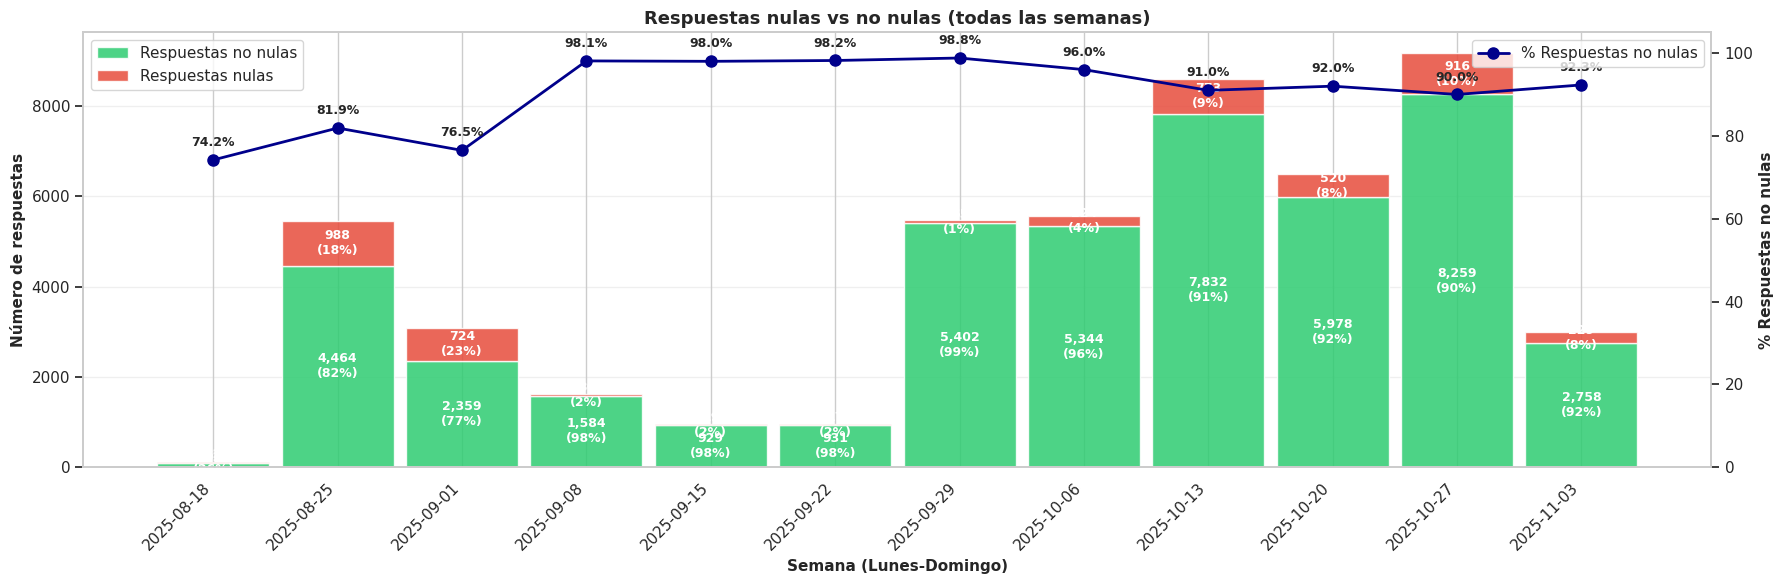

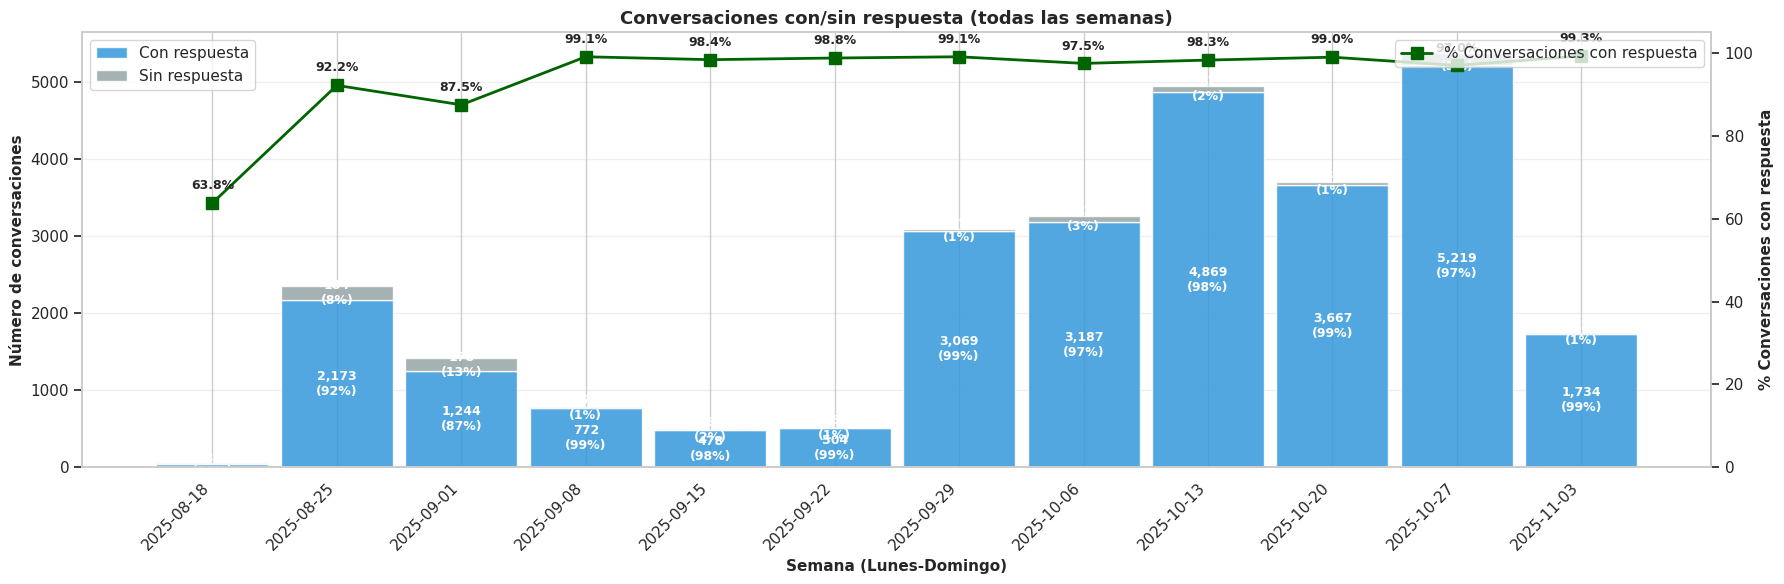

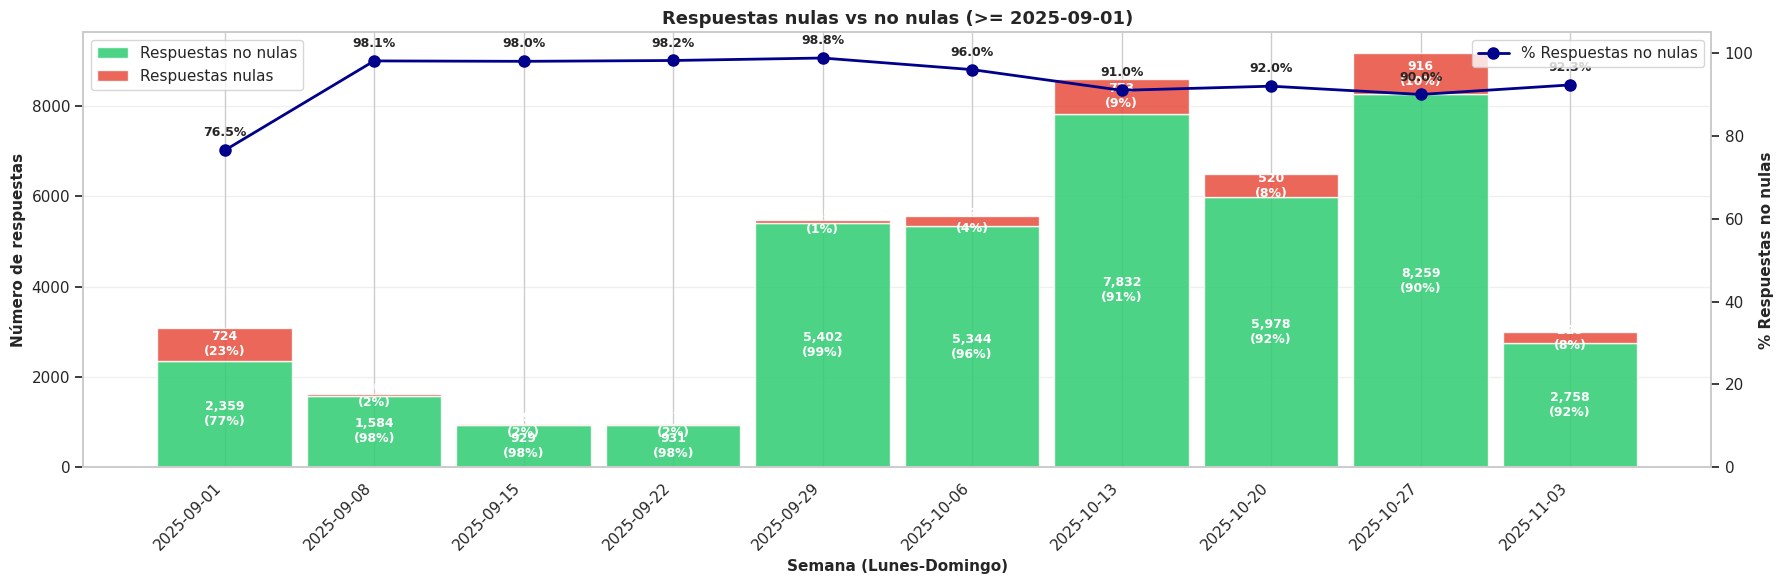

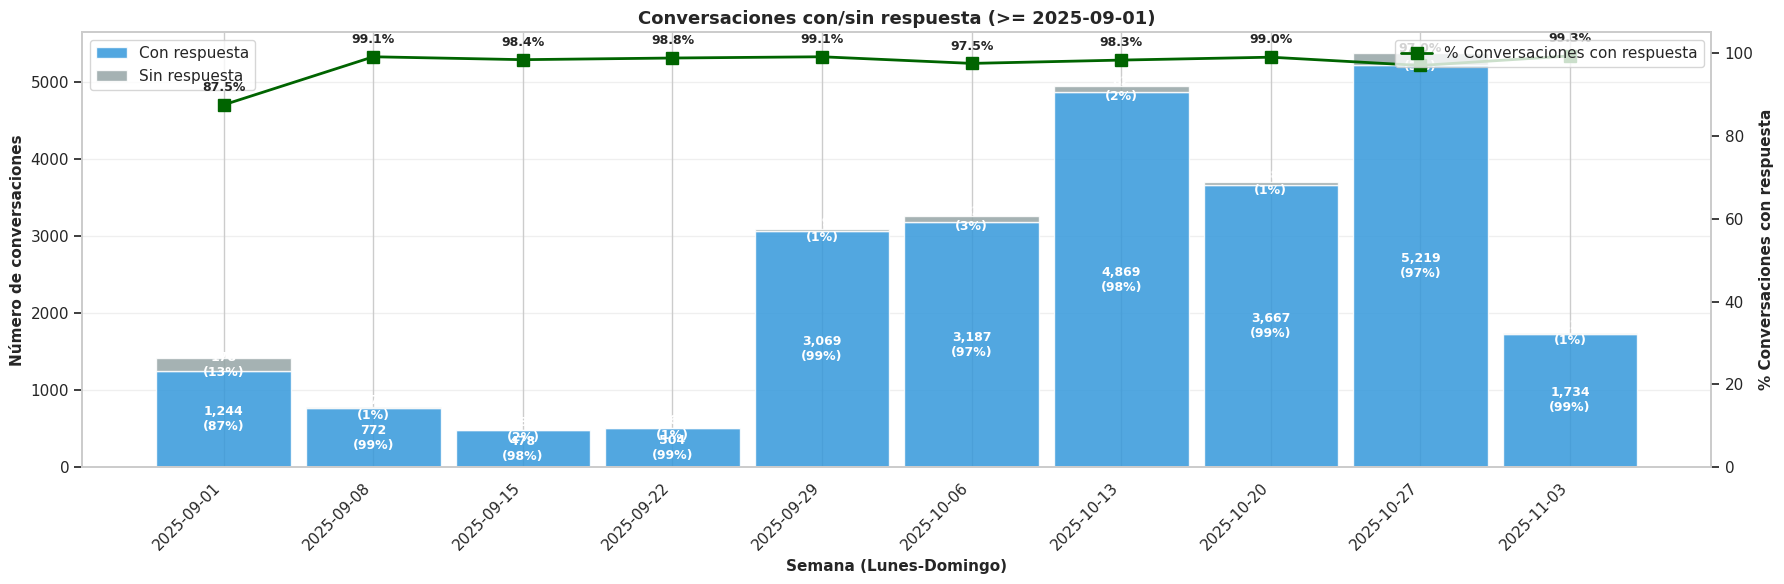

In [64]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.9
plt.rcParams.update({"axes.titlesize": 14, "axes.labelsize": 12})

def _prep_ticks(df):
    idx = df.index
    if np.issubdtype(idx.dtype, np.datetime64):
        labels = idx.strftime("%Y-%m-%d")
    else:
        labels = idx.astype(str)
    positions = np.arange(len(df))
    return positions, labels

def plot_respuestas(df, title_suffix="(todas las semanas)"):
    x_pos, x_labels = _prep_ticks(df)
    fig, ax = plt.subplots(figsize=(18, 6))
    nn = df["respuestas_no_nulas"]
    n = df["respuestas_nulas"]

    ax.bar(x_pos, nn, width=bar_width, label="Respuestas no nulas",
           color="#2ecc71", alpha=0.85)
    ax.bar(x_pos, n, width=bar_width, bottom=nn, label="Respuestas nulas",
           color="#e74c3c", alpha=0.85)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.set_xlabel("Semana (Lunes-Domingo)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Número de respuestas", fontsize=11, fontweight="bold")
    ax.set_title(f"Respuestas nulas vs no nulas {title_suffix}",
                 fontsize=13, fontweight="bold")
    ax.grid(axis="y", alpha=0.3)

    ax2 = ax.twinx()
    ax2.plot(x_pos, df["pct_respuestas_no_nulas"],
             color="darkblue", marker="o", linewidth=2, markersize=8,
             label="% Respuestas no nulas")
    ax2.set_ylabel("% Respuestas no nulas", fontsize=11, fontweight="bold")
    ax2.set_ylim(0, 105)
    ax2.grid(False)

    for i, (nn_val, n_val, pct) in enumerate(zip(nn, n, df["pct_respuestas_no_nulas"])):
        total = nn_val + n_val
        if nn_val > 0:
            ax.text(i, nn_val / 2, f"{nn_val:,}\n({nn_val / total * 100:.0f}%)",
                    ha="center", va="center", fontsize=9, fontweight="bold",
                    color="white")
        if n_val > 0:
            ax.text(i, nn_val + n_val / 2, f"{n_val:,}\n({n_val / total * 100:.0f}%)",
                    ha="center", va="center", fontsize=9, fontweight="bold",
                    color="white")
        ax2.annotate(f"{pct:.1f}%", (i, pct),
                     textcoords="offset points", xytext=(0, 10),
                     ha="center", fontsize=9, fontweight="bold")

    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()

def plot_conversaciones(df, title_suffix="(todas las semanas)"):
    x_pos, x_labels = _prep_ticks(df)
    fig, ax = plt.subplots(figsize=(18, 6))
    cr = df["conversaciones_con_rta"]
    sr = df["conversaciones_sin_rta"]

    ax.bar(x_pos, cr, width=bar_width, label="Con respuesta",
           color="#3498db", alpha=0.85)
    ax.bar(x_pos, sr, width=bar_width, bottom=cr, label="Sin respuesta",
           color="#95a5a6", alpha=0.85)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.set_xlabel("Semana (Lunes-Domingo)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Número de conversaciones", fontsize=11, fontweight="bold")
    ax.set_title(f"Conversaciones con/sin respuesta {title_suffix}",
                 fontsize=13, fontweight="bold")
    ax.grid(axis="y", alpha=0.3)

    ax2 = ax.twinx()
    ax2.plot(x_pos, df["pct_conversaciones_con_rta"],
             color="darkgreen", marker="s", linewidth=2, markersize=8,
             label="% Conversaciones con respuesta")
    ax2.set_ylabel("% Conversaciones con respuesta", fontsize=11, fontweight="bold")
    ax2.set_ylim(0, 105)
    ax2.grid(False)

    for i, (cr_val, sr_val, pct) in enumerate(zip(cr, sr, df["pct_conversaciones_con_rta"])):
        total = cr_val + sr_val
        if cr_val > 0:
            ax.text(i, cr_val / 2, f"{cr_val:,}\n({cr_val / total * 100:.0f}%)",
                    ha="center", va="center", fontsize=9, fontweight="bold",
                    color="white")
        if sr_val > 0:
            ax.text(i, cr_val + sr_val / 2, f"{sr_val:,}\n({sr_val / total * 100:.0f}%)",
                    ha="center", va="center", fontsize=9, fontweight="bold",
                    color="white")
        ax2.annotate(f"{pct:.1f}%", (i, pct),
                     textcoords="offset points", xytext=(0, 10),
                     ha="center", fontsize=9, fontweight="bold")

    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()

# Gráficas con todas las semanas
plot_respuestas(gr_cifras_conversaciones)
plot_conversaciones(gr_cifras_conversaciones)
plt.show()

# Variantes filtradas desde 1-Sep-2025
start_date = pd.Timestamp("2025-09-01")
gr_cifras_sept = gr_cifras_conversaciones.loc[gr_cifras_conversaciones.index >= start_date]

if gr_cifras_sept.empty:
    print("No hay registros desde 1-Sep-2025 en adelante.")
else:
    plot_respuestas(gr_cifras_sept, "(>= 2025-09-01)")
    plot_conversaciones(gr_cifras_sept, "(>= 2025-09-01)")
    plt.show()


In [65]:
import pandas as pd

def resumen_respuestas(df_base, etiqueta):
    total_registros = len(df_base)
    registros_no_nulos = df_base["respuesta"].notna().sum()
    porcentaje_filtrados = (
        (total_registros - registros_no_nulos) / total_registros * 100
        if total_registros else 0
    )

    df_filtrado = df_base[df_base["respuesta"].notna()]
    convs_antes = df_base["fk_tbl_conversaciones_conecta2"].nunique()
    convs_despues = df_filtrado["fk_tbl_conversaciones_conecta2"].nunique()
    pct_convs = (
        (convs_antes - convs_despues) / convs_antes * 100
        if convs_antes else 0
    )

    print(f"[{etiqueta}] Registros totales: {total_registros}")
    print(f"[{etiqueta}] Registros con respuesta no nula: {registros_no_nulos}")
    print(f"[{etiqueta}] % filtrados (respuesta nula): {porcentaje_filtrados:.2f}%")
    print(f"[{etiqueta}] Conversaciones únicas antes: {convs_antes}")
    print(f"[{etiqueta}] Conversaciones únicas después: {convs_despues}")
    print(f"[{etiqueta}] % conversaciones eliminadas: {pct_convs:.2f}%")
    print("-" * 60)

start_date = pd.Timestamp("2025-09-01")
df_total = df_merged_final.copy()

mask_pre = df_total["fecha_hora_inicio"] < start_date
mask_post = df_total["fecha_hora_inicio"] >= start_date

resumen_respuestas(df_total, "Total")
resumen_respuestas(df_total[mask_pre], "Antes 1-Sep-2025")
resumen_respuestas(df_total[mask_post], "Desde 1-Sep-2025")


[Total] Registros totales: 50469
[Total] Registros con respuesta no nula: 45932
[Total] % filtrados (respuesta nula): 8.99%
[Total] Conversaciones únicas antes: 27761
[Total] Conversaciones únicas después: 26953
[Total] % conversaciones eliminadas: 2.91%
------------------------------------------------------------
[Antes 1-Sep-2025] Registros totales: 5576
[Antes 1-Sep-2025] Registros con respuesta no nula: 4556
[Antes 1-Sep-2025] % filtrados (respuesta nula): 18.29%
[Antes 1-Sep-2025] Conversaciones únicas antes: 2415
[Antes 1-Sep-2025] Conversaciones únicas después: 2210
[Antes 1-Sep-2025] % conversaciones eliminadas: 8.49%
------------------------------------------------------------
[Desde 1-Sep-2025] Registros totales: 44893
[Desde 1-Sep-2025] Registros con respuesta no nula: 41376
[Desde 1-Sep-2025] % filtrados (respuesta nula): 7.83%
[Desde 1-Sep-2025] Conversaciones únicas antes: 25346
[Desde 1-Sep-2025] Conversaciones únicas después: 24743
[Desde 1-Sep-2025] % conversaciones el

### Conclusiones - Disponibilidad

**Métricas clave**:

📊 **Por Conversación**:
- **Disponibilidad**: % de conversaciones con AL MENOS una respuesta de la IA
- **No gestionadas**: % de conversaciones donde TODAS las respuestas son NULL

📈 **Por Interacción**:
- **Con respuesta**: % de interacciones individuales que tienen respuesta
- **Sin respuesta**: % de interacciones con respuesta NULL

**Insights**:
- Las barras verdes/azules muestran el servicio funcionando correctamente
- Las barras rojas/grises indican fallas del sistema
- La línea superpuesta muestra la tendencia del porcentaje de disponibilidad
- Este análisis usa el dataset COMPLETO sin filtrar, incluyendo todas las interacciones

---

## 5. Análisis de Fallas de IA (Trazas Langfuse)

**Objetivo**: Identificar y clasificar errores atribuibles al sistema de IA mediante análisis de trazas de ejecución de Langfuse.

**Período analizado**: 11 de octubre - 5 de noviembre 2025  
**Total trazas**: 17,000  
**Conversaciones únicas**: 6,119

In [66]:
# ===== CARGAR TRAZAS DE LANGFUSE =====
print("=" * 80)
print("CARGANDO TRAZAS DE LANGFUSE")
print("=" * 80)

import glob

langfuse_files = sorted(glob.glob("../Archivos/langfuse_split_part*.csv"))
print(f"\nArchivos encontrados: {len(langfuse_files)}")

langfuse_traces = []
for file in langfuse_files:
    df_temp = pd.read_csv(file)
    langfuse_traces.append(df_temp)
    print(f"  ✓ {os.path.basename(file)}: {len(df_temp):,} trazas")

df_langfuse = pd.concat(langfuse_traces, ignore_index=True)
print(f"\n✓ Total trazas cargadas: {len(df_langfuse):,}")
print(f"✓ Conversaciones únicas: {df_langfuse['sessionId'].nunique():,}")

# Filtrar únicamente trazas cuyo name contenga 'main_graph'
original_count = len(df_langfuse)
df_langfuse = df_langfuse[
    df_langfuse["name"].astype(str).str.contains("main_graph", case=False, na=False)
].copy()
filtered_count = len(df_langfuse)
ratio = (filtered_count / original_count * 100) if original_count else 0
print(f"✓ Trazas con 'main_graph' en name: {filtered_count:,} ({ratio:.1f}% del total)")
print(f"✓ Conversaciones únicas (filtradas): {df_langfuse['sessionId'].nunique():,}")

df_langfuse["timestamp"] = pd.to_datetime(
    df_langfuse["timestamp"], format="mixed", errors="coerce"
)

df_langfuse.head()


CARGANDO TRAZAS DE LANGFUSE

Archivos encontrados: 6
  ✓ langfuse_split_part1.csv: 3,000 trazas
  ✓ langfuse_split_part2.csv: 3,000 trazas
  ✓ langfuse_split_part23.csv: 3,000 trazas
  ✓ langfuse_split_part25.csv: 3,000 trazas
  ✓ langfuse_split_part26.csv: 2,000 trazas
  ✓ langfuse_split_part3.csv: 3,000 trazas

✓ Total trazas cargadas: 17,000
✓ Conversaciones únicas: 6,119
✓ Trazas con 'main_graph' en name: 5,999 (35.3% del total)
✓ Conversaciones únicas (filtradas): 5,992


,id,timestamp,name,input,output,metadata,tags,public,htmlPath,latency,totalCost,observations,scores,updatedAt,createdAt,projectId,bookmarked,sessionId,release,version,userId,externalId
3,30f633fa-8d99-44c6-a0f8-181636704175,2025-11-05 22:25:10.244000+00:00,97681b06-2ba5-409f-9c6e-4683504a2876_main_graph,"{'project': 'conecta', 'messages': [{'id': 'd1...",NaN,"{'tags': ['conecta', 'main_workflow', 'agent_e...",[],False,/project/cmglidbeg0008b5zo6fpcsxal/traces/30f6...,11.301,0.0,"['10100f2b-f493-4f0f-8985-436196ec1431', '1192...",[],2025-11-05T22:25:10.773Z,2025-11-05T22:25:10.773Z,cmglidbeg0008b5zo6fpcsxal,False,NaN,NaN,NaN,NaN,NaN
4,70d6a8a0-06bb-480d-9534-4e0fd2f59c97,2025-11-05 22:23:58.094000+00:00,89339cf2-4a18-44dc-a0fe-c40fa5ef9df5_main_graph,"{'project': 'conecta', 'messages': [{'id': 'b7...","{'project': 'conecta', 'sources': ['454'], 'me...","{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'main_workflow']",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/70d6...,12.445,0.0,"['13943aa9-1724-4098-96cc-6e80ce0976d6', '13b4...",[],2025-11-05T22:24:08.402Z,2025-11-05T22:23:46.135Z,cmglidbeg0008b5zo6fpcsxal,False,89339cf2-4a18-44dc-a0fe-c40fa5ef9df5,NaN,NaN,NaN,NaN
8,1d378fce-2484-4807-9a8e-a260e785841a,2025-11-05 22:23:04.599000+00:00,f4f9b91a-483c-4b76-a8d1-228f32cdb08d_main_graph,"{'project': 'conecta', 'messages': [['user', '...","{'project': 'conecta', 'messages': [{'id': '97...","{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'main_workflow']",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/1d37...,1.857,0.0,"['2abcc22f-4fcf-480a-878c-1ef99c0c9cd8', '6e6e...",[],2025-11-05T22:23:44.130Z,2025-11-05T22:23:05.090Z,cmglidbeg0008b5zo6fpcsxal,False,f4f9b91a-483c-4b76-a8d1-228f32cdb08d,NaN,NaN,NaN,NaN
9,f3524834-a5b6-4134-aed5-2d72f98a3139,2025-11-05 22:22:49.532000+00:00,7b078ef8-b665-4a89-9b76-d3c80f9d0c4c_main_graph,"{'project': 'conecta', 'messages': [{'id': '7c...","{'project': 'conecta', 'sources': ['325'], 'me...","{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'main_workflow']",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/f352...,22.300,0.0,"['04494918-f846-4ac8-9f6f-6244e794a882', '06c2...",[],2025-11-05T22:23:05.067Z,2025-11-05T22:22:27.995Z,cmglidbeg0008b5zo6fpcsxal,False,7b078ef8-b665-4a89-9b76-d3c80f9d0c4c,NaN,NaN,NaN,NaN
13,aa1fd97e-a96d-49a6-a81c-6dae1eb6c042,2025-11-05 22:22:11.696000+00:00,cc7a7841-6702-47f4-bd12-028332c8df0b_main_graph,"{'project': 'conecta', 'messages': [['user', '...","{'project': 'conecta', 'messages': [{'id': 'c8...","{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'main_workflow']",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/aa1f...,1.950,0.0,"['03a8e57c-1910-4499-af00-fc35eb422165', '0753...",[],2025-11-05T22:22:27.353Z,2025-11-05T22:22:12.466Z,cmglidbeg0008b5zo6fpcsxal,False,cc7a7841-6702-47f4-bd12-028332c8df0b,NaN,NaN,NaN,NaN


In [71]:
df_langfuse.sessionId.value_counts()

sessionId
4a119b5b-7230-438a-bc68-e6e84f35e7e9_structure_workflow    4
0f211433-3164-4d0b-a88f-91d3f27ac05c_structure_workflow    2
60a4b608-2061-4cbb-a7d2-988aafb02932                       2
383643a4-0ef8-4b12-84ed-cd3b5c7ebf39                       2
06faaf45-0321-41f1-b6fe-ff93d6853e01                       1
                                                          ..
da2e5a2d-3c82-4470-b355-ea9b02325929                       1
0d76bd56-5501-44ff-b8a7-2b13c362f51e                       1
38dea075-3fc7-4efe-a9d2-3380ce75688f                       1
b7d977e1-1f0a-4b00-ae17-196e023303a3                       1
80a92db1-8f56-4502-a53d-7df513c7d240                       1
Name: count, Length: 5992, dtype: int64

In [73]:
df_langfuse[df_langfuse.sessionId == "4a119b5b-7230-438a-bc68-e6e84f35e7e9_structure_workflow"]

,id,timestamp,name,input,output,metadata,tags,public,htmlPath,latency,totalCost,observations,scores,updatedAt,createdAt,projectId,bookmarked,sessionId,release,version,userId,externalId,statusCode,error_type,has_error
3862,c9e69758-d537-44af-8fca-b422b2a3fc5f,2025-11-05 02:27:10.641000+00:00,8c2ac006-ba47-4843-8982-30ffd9f5a496_main_graph,"{'project': 'conecta', 'messages': [['user', '...",NaN,"{'tags': ['conecta', 'main_workflow', 'agent_e...",['conecta_structure_analysis'],False,/project/cmglidbeg0008b5zo6fpcsxal/traces/c9e6...,21.781,0.0,"['08069921-7039-467a-873b-2cb37bd8eaf7', '0845...",[],2025-11-05T02:27:11.208Z,2025-11-05T02:27:11.208Z,cmglidbeg0008b5zo6fpcsxal,False,4a119b5b-7230-438a-bc68-e6e84f35e7e9_structure...,NaN,NaN,nico-test,NaN,NaN,None,False
3863,5e23eade-ba51-4df3-8a2a-d71a5967ca1a,2025-11-05 02:17:20.946000+00:00,03164c4c-543b-41b9-8cb1-98ceb966231a_main_graph,"{'project': 'conecta', 'messages': [['user', '...",NaN,"{'tags': ['conecta', 'main_workflow', 'agent_e...",['conecta_structure_analysis'],False,/project/cmglidbeg0008b5zo6fpcsxal/traces/5e23...,10.967,0.0,"['0020b52a-5f45-46a8-b0a3-35e5e3e7dd10', '0e82...",[],2025-11-05T02:18:57.825Z,2025-11-05T02:17:10.417Z,cmglidbeg0008b5zo6fpcsxal,False,4a119b5b-7230-438a-bc68-e6e84f35e7e9_structure...,NaN,NaN,nico-test,NaN,NaN,None,False
3881,ba7f40e9-3c39-440d-b6a8-8e50c9aed601,2025-11-05 01:25:50.993000+00:00,e65608c7-8fd1-41ce-84a4-891307689407_main_graph,"{'project': 'conecta', 'messages': [['user', '...",NaN,"{'tags': ['conecta', 'main_workflow', 'agent_e...",['conecta_structure_analysis'],False,/project/cmglidbeg0008b5zo6fpcsxal/traces/ba7f...,11.574,0.0,"['02d7b442-ca35-4ab9-81a0-f27c539c6374', '0602...",[],2025-11-05T01:25:51.556Z,2025-11-05T01:25:51.556Z,cmglidbeg0008b5zo6fpcsxal,False,4a119b5b-7230-438a-bc68-e6e84f35e7e9_structure...,NaN,NaN,nico-test,NaN,NaN,None,False
3884,30274326-6937-402c-aad5-2dc1f357cd1b,2025-11-05 00:24:28.842000+00:00,56b57f10-7f23-412a-a532-a360128f0d6b_main_graph,"{'project': 'conecta', 'messages': [['user', '...",NaN,"{'tags': ['conecta', 'main_workflow', 'agent_e...",['conecta_structure_analysis'],False,/project/cmglidbeg0008b5zo6fpcsxal/traces/3027...,23.956,0.0,"['00f503f1-541c-4f1f-96a8-ad6fe4da37a4', '1342...",[],2025-11-05T00:25:46.422Z,2025-11-05T00:24:05.482Z,cmglidbeg0008b5zo6fpcsxal,False,4a119b5b-7230-438a-bc68-e6e84f35e7e9_structure...,NaN,NaN,nico-test,NaN,NaN,None,False


In [74]:
# ===== IDENTIFICAR PATRONES DE ERROR =====
print("="*80)
print("DETECCIÓN DE ERRORES EN TRAZAS")
print("="*80)

# Función para extraer statusCode y mensaje de error del output
def extract_error_info(output_text):
    """
    Extrae el código de estado y mensaje de error del campo output.
    Detecta dos tipos de errores:
    1. Errores HTTP: BadRequestError: Error code: XXX - {...}
    2. Errores de ejecución: ExceptionError: mensaje...
    """
    if pd.isna(output_text):
        return None, None
    
    text = str(output_text)
    
    # Si es un JSON de conversación normal (no error), retornar None
    if text.strip().startswith("{'project':") or text.strip().startswith('{"project":'):
        return None, None
    
    # TIPO 1: Errores HTTP con código explícito
    if 'Error code:' in text:
        # Extraer código numérico
        code_match = re.search(r'Error code: (\d+)', text)
        status_code = int(code_match.group(1)) if code_match else None
        
        # Clasificar tipo de error según el mensaje
        text_lower = text.lower()
        if 'content management policy' in text_lower or 'content_filter' in text_lower:
            error_type = 'Content Policy (400)'
        elif 'rate limit' in text_lower or 'quota exceeded' in text_lower:
            error_type = 'Rate Limit (429)'
        elif 'gateway cannot authenticate' in text_lower:
            error_type = 'Gateway Auth (500)'
        elif 'internal server error' in text_lower:
            error_type = 'Internal Server (500)'
        elif 'bad gateway' in text_lower:
            error_type = 'Bad Gateway (502)'
        elif 'service unavailable' in text_lower:
            error_type = 'Service Unavailable (503)'
        elif 'gateway timeout' in text_lower:
            error_type = 'Gateway Timeout (504)'
        else:
            error_type = f'HTTP Error {status_code}' if status_code else 'Unknown HTTP Error'
        
        return status_code, error_type
    
    # TIPO 2: Errores de ejecución de Python (sin código HTTP)
    text_lower = text.lower()
    
    if 'recursionerror' in text_lower or 'recursion limit' in text_lower:
        return None, 'Recursion Error'
    elif 'timeout' in text_lower and 'timed out' in text_lower:
        return None, 'Timeout'
    elif text.startswith('Exception:') or text.startswith('Error:'):
        return None, 'Execution Error'
    elif 'traceback' in text_lower:
        return None, 'Exception'
    
    # Si no empieza con JSON de conversación pero tampoco es error conocido,
    # podría ser output válido de paso intermedio (advisor_expert_escalation, etc.)
    return None, None

# Extraer información de error
df_langfuse[['statusCode', 'error_type']] = df_langfuse['output'].apply(
    lambda x: pd.Series(extract_error_info(x))
)

df_langfuse['has_error'] = df_langfuse['error_type'].notna()

# Resumen de errores
print(f"\nTrazas con error: {df_langfuse['has_error'].sum():,} ({df_langfuse['has_error'].sum()/len(df_langfuse)*100:.2f}%)")

if df_langfuse['has_error'].sum() > 0:
    print(f"\nDistribución por tipo de error:")
    print(df_langfuse['error_type'].value_counts())
    
    print(f"\nDistribución por statusCode (solo errores HTTP):")
    status_counts = df_langfuse[df_langfuse['statusCode'].notna()]['statusCode'].value_counts().sort_index()
    if len(status_counts) > 0:
        print(status_counts)
    else:
        print("  No hay errores HTTP (todos son errores de ejecución)")
else:
    print("\n  ✓ No se detectaron errores en las trazas")

DETECCIÓN DE ERRORES EN TRAZAS

Trazas con error: 19 (0.32%)

Distribución por tipo de error:
error_type
Content Policy (400)    19
Name: count, dtype: int64

Distribución por statusCode (solo errores HTTP):
statusCode
400.0    19
Name: count, dtype: int64


In [75]:
errores_por_conversacion = (
    df_langfuse.groupby('sessionId')['has_error']
    .any()   # conversation considered “with error” if any row had one
    .value_counts(dropna=True)
)

display(errores_por_conversacion)

sesiones_mixtas = (
    df_langfuse.groupby('sessionId')['has_error']
    .agg(['any', 'all'])
    .query('any == True and all == False')
)

print(f"Sesiones con filas mixtas (errores y éxitos): {len(sesiones_mixtas):,}")
print("Ejemplo:", sesiones_mixtas.index[:5].tolist())


has_error
False    5973
True       19
Name: count, dtype: int64

Sesiones con filas mixtas (errores y éxitos): 0
Ejemplo: []


In [76]:
sesiones_con_error_multi = (
    df_langfuse[df_langfuse["has_error"]]
    .groupby("sessionId")["sessionId"]
    .count()
    .loc[lambda s: s > 1]
)

print(f"Sesiones con error y más de una traza: {len(sesiones_con_error_multi):,}")
print("Ejemplos:", sesiones_con_error_multi.head())


Sesiones con error y más de una traza: 0
Ejemplos: Series([], Name: sessionId, dtype: int64)


In [69]:
# ===== ANÁLISIS POR SESIÓN (CONVERSACIÓN) =====
print("=" * 80)
print("ANÁLISIS DE ERRORES POR CONVERSACIÓN")
print("=" * 80)

session_analysis = df_langfuse.groupby("sessionId").agg(
    num_traces=("sessionId", "size"),
    has_error=("has_error", "any"),
    error_count=("has_error", "sum"),
    avg_latency=("latency", "mean"),
    error_types=(
        "error_type",
        lambda x: ", ".join(x.dropna().unique()) if x.notna().any() else None,
    ),
).reset_index()

session_analysis["error_rate"] = (
    session_analysis["error_count"] / session_analysis["num_traces"] * 100
).round(2)

# Clasificación binaria: Error / Sin error
session_analysis["severity"] = session_analysis["has_error"].map(
    {True: "Error", False: "Sin error"}
)

print(f"\nTotal conversaciones: {len(session_analysis):,}")
print(
    f"Conversaciones con error: {session_analysis['has_error'].sum():,} "
    f"({session_analysis['has_error'].mean()*100:.2f}%)"
)
print("\nDistribución (Error vs Sin error):")
print(session_analysis["severity"].value_counts())

print(f"\n✓ Tasa de fallo general: {session_analysis['has_error'].mean()*100:.1f}%")


ANÁLISIS DE ERRORES POR CONVERSACIÓN



Total conversaciones: 5,992
Conversaciones con error: 19 (0.32%)

Distribución (Error vs Sin error):
severity
Sin error    5973
Error          19
Name: count, dtype: int64

✓ Tasa de fallo general: 0.3%


### 5.1 Comparación Langfuse vs Conversaciones BD

Comparación diaria entre:
- **Trazas Langfuse** (`sessionId`): Ejecuciones registradas del sistema de IA
- **Conversaciones BD** (`fk_tbl_conversaciones_conecta2`): Interacciones almacenadas en base de datos

Objetivo: Identificar correlación entre ambas fuentes y detectar posibles gaps en trazabilidad.

In [34]:
# ===== COMPARACIÓN DIARIA: LANGFUSE VS BD =====
print("="*80)
print("COMPARACIÓN DIARIA: TRAZAS LANGFUSE VS CONVERSACIONES BD")
print("="*80)

# 1. Preparar datos de Langfuse (por día)
df_langfuse_dia = df_langfuse.copy()
df_langfuse_dia['fecha'] = df_langfuse_dia['timestamp'].dt.date

langfuse_por_dia = df_langfuse_dia.groupby('fecha').agg(
    sessionId_unicos=('sessionId', 'nunique'),
    trazas_totales=('sessionId', 'size'),
    sesiones_con_error=('has_error', 'sum')
).reset_index()

print(f"\n📊 Rango de fechas en Langfuse:")
print(f"  Desde: {langfuse_por_dia['fecha'].min()}")
print(f"  Hasta: {langfuse_por_dia['fecha'].max()}")
print(f"  Total días: {len(langfuse_por_dia)}")

# 2. Preparar datos de BD (por día)
df_bd_dia = df_merged_final.copy()
df_bd_dia['fecha'] = df_bd_dia['fecha_hora_inicio'].dt.date

bd_por_dia = df_bd_dia.groupby('fecha').agg(
    conversaciones_totales=('fk_tbl_conversaciones_conecta2', 'nunique'),
    interacciones_totales=('fk_tbl_conversaciones_conecta2', 'size'),
    conversaciones_con_respuesta=('respuesta', lambda x: x.notna().sum()),
    conversaciones_sin_respuesta=('respuesta', lambda x: x.isna().sum())
).reset_index()

# Calcular conversaciones únicas con/sin respuesta a nivel de conversación
conversaciones_por_estado = df_bd_dia.groupby(['fk_tbl_conversaciones_conecta2', 'fecha']).agg(
    tiene_respuesta=('respuesta', lambda x: x.notna().any())
).reset_index()

conv_con_respuesta = conversaciones_por_estado[conversaciones_por_estado['tiene_respuesta']].groupby('fecha').size()
conv_sin_respuesta = conversaciones_por_estado[~conversaciones_por_estado['tiene_respuesta']].groupby('fecha').size()

bd_por_dia = bd_por_dia.merge(
    conv_con_respuesta.reset_index(name='conv_unicas_con_respuesta'),
    on='fecha',
    how='left'
).merge(
    conv_sin_respuesta.reset_index(name='conv_unicas_sin_respuesta'),
    on='fecha',
    how='left'
)

bd_por_dia['conv_unicas_con_respuesta'] = bd_por_dia['conv_unicas_con_respuesta'].fillna(0).astype(int)
bd_por_dia['conv_unicas_sin_respuesta'] = bd_por_dia['conv_unicas_sin_respuesta'].fillna(0).astype(int)

print(f"\n📊 Rango de fechas en BD:")
print(f"  Desde: {bd_por_dia['fecha'].min()}")
print(f"  Hasta: {bd_por_dia['fecha'].max()}")
print(f"  Total días: {len(bd_por_dia)}")

# 3. Merge de ambos dataframes por fecha
comparacion = pd.merge(
    langfuse_por_dia,
    bd_por_dia,
    on='fecha',
    how='outer',
    suffixes=('_langfuse', '_bd')
)

# Rellenar NaN con 0 para días sin datos
comparacion = comparacion.fillna(0)

# Calcular diferencias y ratios
comparacion['diff_conversaciones'] = comparacion['conversaciones_totales'] - comparacion['sessionId_unicos']
comparacion['ratio_langfuse_bd'] = np.where(
    comparacion['conversaciones_totales'] > 0,
    comparacion['sessionId_unicos'] / comparacion['conversaciones_totales'],
    0
)

# Ordenar por fecha
comparacion = comparacion.sort_values('fecha')

print(f"\n📈 Resumen comparativo:")
print(f"  Días con datos en ambas fuentes: {(comparacion['sessionId_unicos'] > 0) & (comparacion['conversaciones_totales'] > 0).sum()}")
print(f"  Días solo en Langfuse: {((comparacion['sessionId_unicos'] > 0) & (comparacion['conversaciones_totales'] == 0)).sum()}")
print(f"  Días solo en BD: {((comparacion['sessionId_unicos'] == 0) & (comparacion['conversaciones_totales'] > 0)).sum()}")

print(f"\n📊 Totales generales:")
print(f"  SessionId únicos (Langfuse): {comparacion['sessionId_unicos'].sum():,.0f}")
print(f"  Conversaciones únicas (BD): {comparacion['conversaciones_totales'].sum():,.0f}")
print(f"  Diferencia: {comparacion['diff_conversaciones'].sum():,.0f}")
print(f"  Ratio promedio Langfuse/BD: {comparacion['ratio_langfuse_bd'].mean():.2%}")

# Mostrar primeras y últimas filas
print(f"\n📋 Primeras 10 filas de comparación:")
print(comparacion.head(10).to_string(index=False))

print(f"\n📋 Últimas 10 filas de comparación:")
print(comparacion.tail(10).to_string(index=False))

COMPARACIÓN DIARIA: TRAZAS LANGFUSE VS CONVERSACIONES BD

📊 Rango de fechas en Langfuse:
  Desde: 2025-10-11
  Hasta: 2025-11-05
  Total días: 11

📊 Rango de fechas en BD:
  Desde: 2025-08-23
  Hasta: 2025-11-06
  Total días: 76

📈 Resumen comparativo:
  Días con datos en ambas fuentes: 0     False
1     False
2     False
3     False
4     False
      ...  
71    False
72    False
73    False
74    False
75    False
Name: sessionId_unicos, Length: 76, dtype: bool
  Días solo en Langfuse: 0
  Días solo en BD: 65

📊 Totales generales:
  SessionId únicos (Langfuse): 5,992
  Conversaciones únicas (BD): 27,761
  Diferencia: 21,769
  Ratio promedio Langfuse/BD: 19.19%

📋 Primeras 10 filas de comparación:
     fecha  sessionId_unicos  trazas_totales  sesiones_con_error  conversaciones_totales  interacciones_totales  conversaciones_con_respuesta  conversaciones_sin_respuesta  conv_unicas_con_respuesta  conv_unicas_sin_respuesta  diff_conversaciones  ratio_langfuse_bd
2025-08-23               0

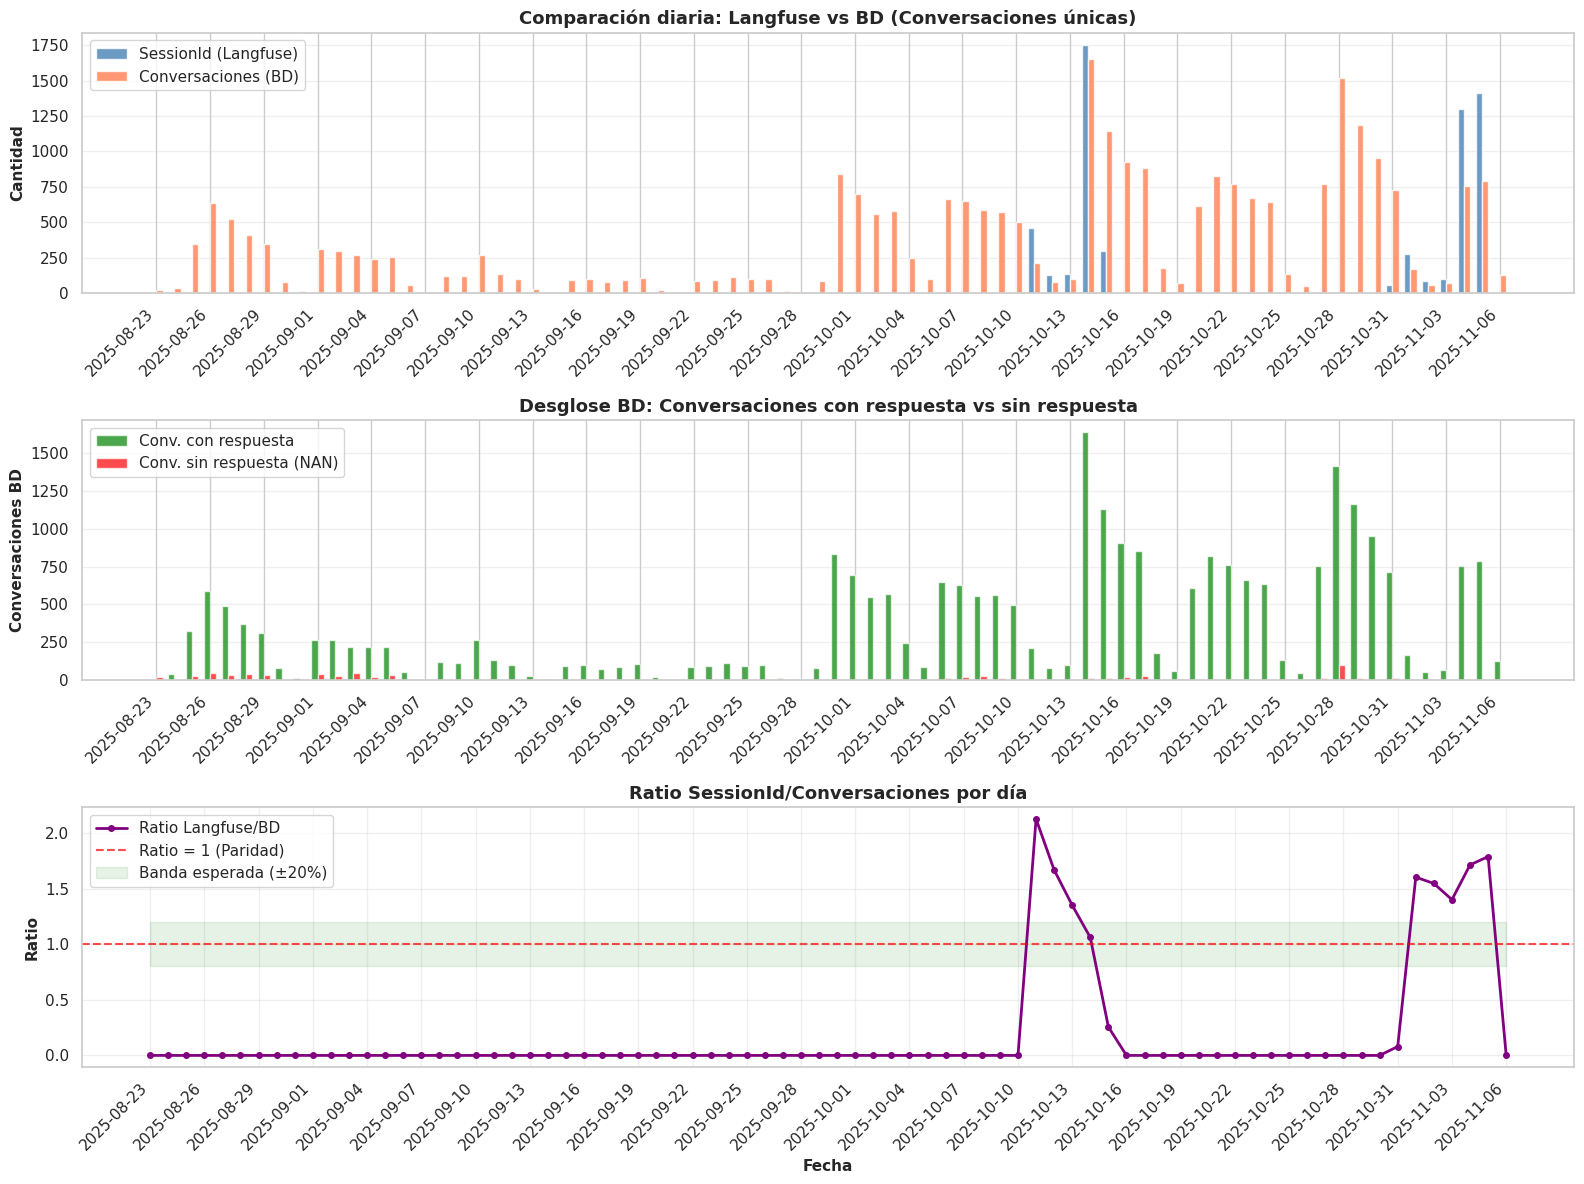


📊 Análisis del Ratio Langfuse/BD:
  Promedio: 19.19%
  Mediana: 0.00%
  Desviación estándar: 52.36%
  Mínimo: 0.00%
  Máximo: 212.56%


In [35]:
# ===== VISUALIZACIÓN COMPARATIVA =====

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Filtrar solo fechas con datos en al menos una fuente
comparacion_plot = comparacion[(comparacion['sessionId_unicos'] > 0) | (comparacion['conversaciones_totales'] > 0)].copy()

# Gráfico 1: Comparación de volúmenes totales
ax1 = axes[0]
width = 0.35
x = np.arange(len(comparacion_plot))

bars1 = ax1.bar(x - width/2, comparacion_plot['sessionId_unicos'], width, 
                label='SessionId (Langfuse)', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, comparacion_plot['conversaciones_totales'], width,
                label='Conversaciones (BD)', color='coral', alpha=0.8)

ax1.set_ylabel('Cantidad', fontsize=11, fontweight='bold')
ax1.set_title('Comparación diaria: Langfuse vs BD (Conversaciones únicas)', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Mostrar solo cada N fechas para evitar saturación
step = max(1, len(comparacion_plot) // 20)
ax1.set_xticks(x[::step])
ax1.set_xticklabels([str(d) for d in comparacion_plot['fecha'].iloc[::step]], rotation=45, ha='right')

# Gráfico 2: Desglose BD (Con respuesta vs Sin respuesta)
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, comparacion_plot['conv_unicas_con_respuesta'], width,
                label='Conv. con respuesta', color='green', alpha=0.7)
bars4 = ax2.bar(x + width/2, comparacion_plot['conv_unicas_sin_respuesta'], width,
                label='Conv. sin respuesta (NAN)', color='red', alpha=0.7)

ax2.set_ylabel('Conversaciones BD', fontsize=11, fontweight='bold')
ax2.set_title('Desglose BD: Conversaciones con respuesta vs sin respuesta', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticks(x[::step])
ax2.set_xticklabels([str(d) for d in comparacion_plot['fecha'].iloc[::step]], rotation=45, ha='right')

# Gráfico 3: Ratio Langfuse/BD
ax3 = axes[2]
line = ax3.plot(x, comparacion_plot['ratio_langfuse_bd'], 
                marker='o', color='purple', linewidth=2, markersize=4, label='Ratio Langfuse/BD')
ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Ratio = 1 (Paridad)')
ax3.fill_between(x, 0.8, 1.2, color='green', alpha=0.1, label='Banda esperada (±20%)')

ax3.set_ylabel('Ratio', fontsize=11, fontweight='bold')
ax3.set_xlabel('Fecha', fontsize=11, fontweight='bold')
ax3.set_title('Ratio SessionId/Conversaciones por día', fontsize=13, fontweight='bold')
ax3.legend(loc='upper left')
ax3.grid(axis='both', alpha=0.3)
ax3.set_xticks(x[::step])
ax3.set_xticklabels([str(d) for d in comparacion_plot['fecha'].iloc[::step]], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Estadísticas del ratio
print(f"\n📊 Análisis del Ratio Langfuse/BD:")
print(f"  Promedio: {comparacion_plot['ratio_langfuse_bd'].mean():.2%}")
print(f"  Mediana: {comparacion_plot['ratio_langfuse_bd'].median():.2%}")
print(f"  Desviación estándar: {comparacion_plot['ratio_langfuse_bd'].std():.2%}")
print(f"  Mínimo: {comparacion_plot['ratio_langfuse_bd'].min():.2%}")
print(f"  Máximo: {comparacion_plot['ratio_langfuse_bd'].max():.2%}")

## Clasificación IA (Gestionada vs. NO Gestionada)

In [33]:
try:
    from dotenv import load_dotenv
    load_dotenv()
    print('Variables de entorno cargadas desde .env (si existía).')
except ModuleNotFoundError:
    print('python-dotenv no está instalado; continúa sin cargar archivo .env.')

api_key = os.getenv('GOOGLE_API_KEY')
if not api_key:
    raise RuntimeError('Configura la variable de entorno GEMINI_API_KEY antes de continuar.')

import google.generativeai as genai
from google.api_core import exceptions

genai.configure(api_key=api_key)
MODEL_ID = 'gemini-2.5-flash'
model = genai.GenerativeModel(MODEL_ID)

Variables de entorno cargadas desde .env (si existía).


RuntimeError: Configura la variable de entorno GEMINI_API_KEY antes de continuar.

In [143]:
SYSTEM_PROMPT = """Eres analista de control de calidad del asistente virtual de Banco Davivienda.

Tu tarea es etiquetar la siguiente interacción en EXACTAMENTE una de las siguientes categorías.
Las categorías permitidas son: 'Pregunta valida', 'Sin información', 'Pregunta no valida', o 'Solicitud Paso Experto'.

Reglas de Etiquetado:
1. 'Pregunta valida': la consulta del usuario está relacionada con productos bancarios, procesos de Davivienda, O temas OPERACIONALES relevantes para Davivienda y la respuesta del bot es pertinente y útil. 
2. 'Sin información': La respuesta del bot indica explicitamente que NO tiene información (p. ej., "Lo siento, no encontré..."). Priorizar esta sobre 'Pregunta valida'.
3. 'Pregunta no valida': la consulta es ambigua o NO está relacionada con el contexto bancario o OPERACIONAL DE Davivienda (ej: clima, política), o el enunciado está vacío/incompleto. 
4. 'Solicitud Paso Experto': Petición directa de hablar con un asesor, humano o ejecutivo.

Devuelve JSON con las claves:
- conversation_id (número entero de la conversación).
- category (una de las categorías válidas).
- rationale (breve explicación en español sobre la decisión).

Instrucciones adicionales:
- Prioriza 'Sin información' cuando el bot exprese que no tiene datos, incluso si la pregunta fue válida.
- Etiqueta como 'Solicitud Paso Experto' cualquier petición directa de escalar a un humano aunque la respuesta no lo conceda.
- Usa 'Pregunta no valida' si la pregunta está vacía, contiene caracteres irrelevantes o trata temas ajenos al contexto operativo de Davivienda.
- En los demás casos utiliza 'Pregunta valida' siempre que la respuesta responda a la pregunta.

IMPORTANTE: TU RESPUESTA DEBE SER ÚNICAMENTE EL OBJETO JSON COMPLETO. 
NO AÑADAS NINGÚN BLOQUE DE CÓDIGO (NO USES ```JSON) NI TEXTO EXPLICATIVO."""

VALID_CATEGORIES = {
    'Pregunta valida', 'Sin información', 'Pregunta no valida', 'Solicitud Paso Experto',
}

CATEGORY_ALIASES = {
    'pregunta válida': 'Pregunta valida', 'pregunta valida': 'Pregunta valida', 
    'pregunta no válida': 'Pregunta no valida', 'sin informacion': 'Sin información', 
    'sin información': 'Sin información', 'solicitud paso experto': 'Solicitud Paso Experto',
}


def safe_strip(val):
    if pd.isna(val):
        return ''
    return str(val).strip()

def build_prompt(row):
    conversation_id = int(row.get('fk_tbl_conversaciones_conecta2'))
    pregunta = safe_strip(row.get('pregunta'))
    respuesta = safe_strip(row.get('respuesta'))
    if not pregunta:
        pregunta = '[pregunta vacía]'
    if not respuesta:
        respuesta = '[respuesta vacía]'
    return (
        f"{SYSTEM_PROMPT}\n\n"
        f"ID conversacion: {conversation_id}\n"
        f"Pregunta del usuario: {pregunta}\n"
        f"Respuesta del agente: {respuesta}\n\n"
        'Devuelve solo el JSON requerido.'
    )
    
def parse_gemini_json(text):
    cleaned = text.strip()
    if cleaned.startswith('```'):
        cleaned = cleaned[3:]
        cleaned = cleaned.lstrip()
        if cleaned.lower().startswith('json'):
            cleaned = cleaned[4:].lstrip()
        if cleaned.endswith('```'):
            cleaned = cleaned[:-3]
    if cleaned.lower().startswith('json'):
        cleaned = cleaned[4:].lstrip()
    return json.loads(cleaned)

def classify_with_gemini(row, max_retries=3, base_sleep_seconds=2.0, quota_cooldown_seconds=45):
    prompt = ''.join(build_prompt(row))
    last_error = None
    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
        except exceptions.ResourceExhausted as exc:
            wait_time = max(quota_cooldown_seconds, base_sleep_seconds * (attempt + 1) * 5)
            print(f'Límite de cuota alcanzado; esperando {wait_time:.0f}s antes de reintentar...')
            time.sleep(wait_time)
            last_error = exc
            continue
        except exceptions.GoogleAPICallError as exc:
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Error de la API ({exc.__class__.__name__}); reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
            last_error = exc
            continue

        candidate_text = ''
        if response.candidates:
            first_candidate = response.candidates[0]
            for part in first_candidate.content.parts:
                if getattr(part, 'text', None):
                    candidate_text += part.text
        candidate_text = candidate_text.strip()
        if not candidate_text:
            last_error = ValueError('Respuesta sin texto interpretable del modelo.')
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Sin texto interpretable; reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
            continue
        try:
            parsed = parse_gemini_json(candidate_text)
            category_raw = (parsed.get('category') or '').strip()
            category = CATEGORY_ALIASES.get(category_raw.lower(), category_raw)
            if category not in VALID_CATEGORIES:
                raise KeyError(f'Categoría no válida recibida: {category_raw}')
            return {
                'conversation_id': int(parsed.get('conversation_id', row.get('fk_tbl_conversaciones_conecta2'))),
                'category': category,
                'rationale': (parsed.get('rationale') or '').strip(),
            }
        except (json.JSONDecodeError, KeyError, AttributeError) as exc:
            last_error = exc
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Error interpretando respuesta (intento {attempt + 1}/{max_retries}): {exc}. Reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
    raise ValueError(f'No se pudo interpretar la respuesta de Gemini tras {max_retries} intentos. Último error: {last_error}')

In [144]:
# MAX_INTERACTIONS = None  # Cambia a None para clasificar todo el dataset (incrementa el costo).
# subset = df_nuevos if MAX_INTERACTIONS is None else df_nuevos.head(MAX_INTERACTIONS)

# print(f'Clasificando {subset.shape[0]} interacciones...')

# resultados = []
# for index, row in enumerate(subset.to_dict(orient='records'), start=1):
#     resultado = classify_with_gemini(row)
#     resultados.append(resultado)
#     if index % 25 == 0:
#         print(f'{index} interacciones clasificadas...')

# clasificacion = pd.DataFrame(resultados)

In [145]:
# resultados_previos_cop = resultados_previos

In [146]:
from concurrent.futures import ThreadPoolExecutor

# Obtén los IDs ya evaluados en resultados
ids_ya_analizados = conecta_2_evaluados.conversation_id.unique()

# Si existe resultados_paralelo_parcial.csv, excluye también esos IDs
if os.path.exists('resultados_paralelo_parcial.csv'):
    resultados_previos = pd.read_csv('resultados_paralelo_parcial.csv')
    ids_ya_procesados = set(resultados_previos['conversation_id'])
    print(f"Ya procesados previamente: {len(ids_ya_procesados)}")
else:
    ids_ya_procesados = set()

# Filtra las filas pendientes en df_nuevos
pendientes = df_nuevos[
    ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)
    & ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_procesados)
]

print(f"Pendientes por evaluar: {len(pendientes)}")

Ya procesados previamente: 1392
Pendientes por evaluar: 5237


In [182]:
import os
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# --- IDs ya evaluados ---
ids_ya_analizados = set(conecta_2_evaluados.conversation_id.unique())

# --- Excluir ya procesados si existe archivo parcial ---
if os.path.exists('resultados_paralelo_parcial.csv'):
    resultados_previos = pd.read_csv('resultados_paralelo_parcial.csv')
    ids_ya_procesados = set(resultados_previos['conversation_id'])
    print(f"Ya procesados previamente: {len(ids_ya_procesados)}")
else:
    resultados_previos = pd.DataFrame()
    ids_ya_procesados = set()

# --- Filtra los pendientes para excluir los ya evaluados y procesados ---
pendientes = df_nuevos[
    ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)
    & ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_procesados)
]
print(f"Pendientes por analizar tras excluir previos: {len(pendientes)}")

# --- Funciones de procesamiento ---
def split_dataframe(df, n):
    return np.array_split(df, n)

def process_rows(rows, subset_idx=None):
    print(f"Subset {subset_idx} iniciado con {len(rows)} filas")
    resultados = []
    for row in tqdm(rows.to_dict(orient='records'), desc=f"Subset {subset_idx}", position=subset_idx):
        resultados.append(classify_with_gemini(row))
    return resultados

num_workers = 4  # Ajusta según tu CPU y cuota API
subsets = split_dataframe(pendientes, num_workers)

# --- Mantén los resultados previos y agrega solo los nuevos ---
resultados_paralelo = resultados_previos.to_dict(orient='records') if not resultados_previos.empty else []

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [
        executor.submit(process_rows, subset, idx)
        for idx, subset in enumerate(subsets)
    ]
    for i, future in enumerate(futures, 1):
        subset_result = future.result()
        resultados_paralelo.extend(subset_result)
        # Guarda incrementalmente, sin perder los previos
        pd.DataFrame(resultados_paralelo).to_csv('resultados_paralelo_parcial.csv', index=False)
        print(f"Guardado parcial tras subset {i}: {len(resultados_paralelo)} filas")

# resultados_paralelo contiene todos los resultados nuevos y previos

clasificacion_total_parcial = pd.DataFrame(resultados_paralelo)
clasificacion_total_parcial.to_csv('resultados_clasificacion_total_parcial.csv', index=False)

c:\Users\gabrieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Ya procesados previamente: 1392
Pendientes por analizar tras excluir previos: 5237
Subset 0 iniciado con 1310 filas
Subset 1 iniciado con 1309 filas
Subset 2 iniciado con 1309 filas
Subset 3 iniciado con 1309 filas


Subset 0:   0%|          | 0/1310 [00:00<?, ?it/s]


Subset 0:   0%|          | 1/1310 [00:04<1:29:17,  4.09s/it]


Subset 0:   0%|          | 2/1310 [00:07<1:19:13,  3.63s/it]




Subset 0:   0%|          | 3/1310 [00:11<1:19:17,  3.64s/it]


Subset 0:   0%|          | 5/1310 [00:17<1:09:17,  3.19s/it]

Subset 0:   0%|          | 6/1310 [00:20<1:08:51,  3.17s/it]


Subset 0:   1%|          | 7/1310 [00:25<1:21:19,  3.75s/it]




Subset 0:   1%|          | 8/1310 [00:29<1:22:10,  3.79s/it]



Subset 0:   1%|          | 9/1310 [00:36<1:45:03,  4.84s/it]


Subset 0:   1%|          | 11/1310 [00:41<1:18:12,  3.61s/it]

Subset 0:   1%|          | 12/1310 [00:44<1:14:57,  3.46s/it]


Subset 0:   1%|          | 14/1310 [00:49<1:04:20,  2.98s/it]






Subset 0:   1%|          | 16/1310 [01:00<1:27:14,  4.05s/it]


Subset 0:   1%|▏         | 17/1310 [01:04<1:24:18,  3.91s/it]


Subset 0:   1%|▏         | 18/1310 [01:06<1:11:16,  3.31s/it]


Subset 0:   1%|▏         | 19/1310 [01:10<1:15:55,  

Guardado parcial tras subset 1: 3570 filas












































































Subset 1: 100%|██████████| 1309/1309 [1:36:54<00:00,  4.44s/it]


Guardado parcial tras subset 2: 4879 filas
Guardado parcial tras subset 3: 6188 filas


























































































Subset 3: 100%|██████████| 1309/1309 [1:39:17<00:00,  4.55s/it]


Guardado parcial tras subset 4: 7497 filas


In [183]:
df_nuevos_cop = df_nuevos.copy()
clasificacion_total = pd.DataFrame(resultados_paralelo) 

In [184]:
clasificacion_total = clasificacion_total[["conversation_id", "category", "rationale"]]

In [185]:
# El cumcount debe numerar las interacciones dentro de cada conversación
missing_mask = ~df_nuevos_cop['fk_tbl_conversaciones_conecta2'].isin(clasificacion_total['conversation_id'])
if missing_mask.any():
    df_defaults = (
        df_nuevos_cop.loc[missing_mask, ['fk_tbl_conversaciones_conecta2']]
        .rename(columns={'fk_tbl_conversaciones_conecta2': 'conversation_id'})
    )
    df_defaults['category'] = 'Pregunta valida'
    df_defaults['rationale'] = 'Pregunta generica'
    clasificacion_total = pd.concat([clasificacion_total, df_defaults], ignore_index=True)

clasificacion_total['merge_idx'] = clasificacion_total.groupby('conversation_id').cumcount()
df_nuevos_cop['merge_idx'] = df_nuevos_cop.groupby('fk_tbl_conversaciones_conecta2').cumcount()

auditoria = clasificacion_total.merge(
    df_nuevos_cop[['fk_tbl_conversaciones_conecta2', 'fecha_hora_inicio','pregunta', 'respuesta', 'flg_experto', 'motivo_experto', 'REGIONAL','merge_idx', 'calificacion_pregunta_1', 'calificacion_pregunta_2', 'correo']],
    left_on=['conversation_id', 'merge_idx'],
    right_on=['fk_tbl_conversaciones_conecta2', 'merge_idx'],
    how='left'
)

auditoria['fecha'] = pd.to_datetime(auditoria['fecha_hora_inicio']).dt.date
auditoria["fecha_hora_inicio"] = pd.to_datetime(auditoria["fecha_hora_inicio"])
auditoria["fecha"] = auditoria["fecha_hora_inicio"].dt.date

# cols = ['conversation_id', 'category', 'rationale', 'pregunta', 'respuesta', 'flg_experto']
# auditoria.head()

In [186]:
def clasificacion_no_gestionada(group):
    categorias = group['category'].astype(str).str.strip().str.lower()
    # 1. Preguntas temas no bancarios: al menos una 'pregunta no valida' y ninguna 'sin información'
    if (categorias == 'pregunta no valida').any() and not (categorias == 'sin información').any():
        return 'Preguntas temas no bancarios'
    # 2. Al menos una 'sin información'
    if (categorias == 'sin información').any():
        return 'Sin información'
    # 3. Al menos una 'solicitud paso experto' y ninguna 'sin información'
    if (categorias == 'solicitud paso experto').any() and not (categorias == 'sin información').any():
        return 'Usuario solicitó paso a experto'
    # Si no cumple ninguna, es mezcla de categorías no contemplada
    return 'Otro'

def clasificacion_principal(group):
    categorias_no_gestionada = {'Sin información', 'Solicitud Paso Experto', 'Pregunta no valida'}
    if any(group['category'].isin(categorias_no_gestionada)):
        return 'No Gestionada Conecta'
    else:
        return 'Gestionada Conecta'

def clasificacion_gestionada(group):
    if group['motivo_experto'].isna().all():
        return 'Conecta Retuvo'
    if group['motivo_experto'].notna().any():
        return 'Ofreció PE'
    return 'Otro'


In [37]:
resultados = resultados_paralelo

In [187]:
auditoria.fecha = pd.to_datetime(auditoria.fecha)

In [188]:
for cid, group in auditoria.groupby('conversation_id'):
    grupo_principal = clasificacion_principal(group)
    motivo_experto_flag = int(group['motivo_experto'].notna().any())
    flg_experto_flag = int((group['flg_experto'] == 1).any())

    motivos = group['motivo_experto'].dropna().unique()
    motivo_experto_unicos = motivos[0] if len(motivos) > 0 else None
    regional = group['REGIONAL'].dropna().iloc[0] if group['REGIONAL'].notna().any() else None
    calif1_mean = pd.to_numeric(group['calificacion_pregunta_1'], errors='coerce').mean()
    calif2_mean = pd.to_numeric(group['calificacion_pregunta_2'], errors='coerce').mean()
    fecha_conv = group['fecha'].min()
    filas_por_conversacion = len(group)
    correo = group['correo']

    if grupo_principal == 'No Gestionada Conecta':
        subgrupo = clasificacion_no_gestionada(group)
    else:
        subgrupo = clasificacion_gestionada(group)

    resultados.append({
        'conversation_id': cid,
        'grupo_principal': grupo_principal,
        'subgrupo': subgrupo,
        'flg_experto_flag': flg_experto_flag,
        'motivo_experto_flag': motivo_experto_flag,
        'motivo_experto_unicos': motivo_experto_unicos,
        'REGIONAL': regional,
        'calificacion_pregunta_1_mean': calif1_mean,
        'calificacion_pregunta_2_mean': calif2_mean,
        'fecha': fecha_conv,
        'filas_por_conversacion': filas_por_conversacion,
        'correo': correo
    })
    
df_resultados = pd.DataFrame(resultados)

# Filtra correctamente y haz copia para evitar el warning
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()
no_gestionada.loc[:, 'percent_sobre_NGC'] = no_gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / ngc_convs * 100
no_gestionada.loc[:, 'percent_sobre_total'] = no_gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / df_resultados['conversation_id'].nunique() * 100

ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_sum=('motivo_experto_flag', 'sum'),
    sobre_NGC=('percent_sobre_NGC', 'first'),
    sobre_total=('percent_sobre_total', 'first')
).reset_index()

for _, row in ngc_sub.iterrows():
    print(f"{row['subgrupo']}: {row['conversaciones']} conversaciones ({row['sobre_NGC']:.2f}% de NGC, {row['sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} | motivo_experto.notna(): {row['motivo_experto_sum']}")

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_sum'].sum()}")

# Aplica igual para Gestionada Conecta
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()
gestionada.loc[:, 'percent_sobre_GC'] = gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / gc_convs * 100
gestionada.loc[:, 'percent_sobre_total'] = gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / df_resultados['conversation_id'].nunique() * 100

gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_sum=('motivo_experto_flag', 'sum'),
    sobre_GC=('percent_sobre_GC', 'first'),
    sobre_total=('percent_sobre_total', 'first')
).reset_index()

for _, row in gc_sub.iterrows():
    print(f"{row['subgrupo']}: {row['conversaciones']} conversaciones ({row['sobre_GC']:.2f}% de GC, {row['sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} | motivo_experto.notna(): {row['motivo_experto_sum']}")

Preguntas temas no bancarios: 440 conversaciones (23.89% de NGC, 2.22% del total) | flg_experto==1: 61 | motivo_experto.notna(): 183
Sin información: 1152 conversaciones (62.54% de NGC, 5.82% del total) | flg_experto==1: 146 | motivo_experto.notna(): 491
Usuario solicitó paso a experto: 250 conversaciones (13.57% de NGC, 1.26% del total) | flg_experto==1: 125 | motivo_experto.notna(): 240

Suma total motivo_experto.notna() en No Gestionada Conecta: 914
Conecta Retuvo: 14737 conversaciones (79.25% de GC, 74.50% del total) | flg_experto==1: 0 | motivo_experto.notna(): 0
Ofreció PE: 3859 conversaciones (20.75% de GC, 19.51% del total) | flg_experto==1: 2039 | motivo_experto.notna(): 4601


In [189]:
# Agrupar por conversación y aplicar clasificaciones
resultados = []

# Identifica los conversation_id que solo están en conecta_2_evaluados
ids_evaluados = set(conecta_2_evaluados['conversation_id'])
ids_auditoria = set(auditoria['conversation_id'])
solo_evaluados = ids_evaluados - ids_auditoria

# Primero, agrega los registros originales de conecta_2_evaluados para los que no están en auditoria
for _, row in conecta_2_evaluados[conecta_2_evaluados['conversation_id'].isin(solo_evaluados)].iterrows():
    resultados.append(row.to_dict())

# Luego, concatena y agrupa como antes (esto sobrescribirá los duplicados, pero no los únicos)
# auditoria_full = pd.concat([conecta_2_evaluados, auditoria], ignore_index=True)

for cid, group in auditoria.groupby('conversation_id'):
    # Solo procesa los que no están ya agregados
    if cid in solo_evaluados:
        continue
    grupo_principal = clasificacion_principal(group)
    motivo_experto_flag = int(group['motivo_experto'].notna().any())
    flg_experto_flag = int((group['flg_experto'] == 1).any())

    motivos = group['motivo_experto'].dropna().unique()
    motivo_experto_unicos = motivos[0] if len(motivos) > 0 else None
    regional = group['REGIONAL'].dropna().iloc[0] if group['REGIONAL'].notna().any() else None
    correo = group['correo'].dropna().iloc[0] if 'correo' in group.columns and group['correo'].notna().any() else None
    calif1_mean = pd.to_numeric(group['calificacion_pregunta_1'], errors='coerce').mean()
    calif2_mean = pd.to_numeric(group['calificacion_pregunta_2'], errors='coerce').mean()
    fecha_conv = group['fecha'].min()
    filas_por_conversacion = len(group)

    if grupo_principal == 'No Gestionada Conecta':
        subgrupo = clasificacion_no_gestionada(group)
    else:
        subgrupo = clasificacion_gestionada(group)

    resultados.append({
        'conversation_id': cid,
        'grupo_principal': grupo_principal,
        'subgrupo': subgrupo,
        'flg_experto_flag': flg_experto_flag,
        'motivo_experto_flag': motivo_experto_flag,
        'motivo_experto_unicos': motivo_experto_unicos,
        'REGIONAL': regional,
        'calificacion_pregunta_1_mean': calif1_mean,
        'calificacion_pregunta_2_mean': calif2_mean,
        'fecha': fecha_conv,
        'filas_por_conversacion': filas_por_conversacion,
        'correo': correo
    })

In [190]:
df_resultados = pd.DataFrame(resultados)

In [191]:
# Guarda el DataFrame en la carpeta de salidas
output_path = r'../Salidas/df_resultados.csv'
df_resultados.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")

Archivo guardado en: ../Salidas/df_resultados.csv


In [192]:
# Muestra solo las filas con calificación válida y agrupa por subgrupo y calificación promedio (redondeada para evitar decimales infinitos)
df_validas = df_resultados[~df_resultados['calificacion_pregunta_2_mean'].isna()].copy()
df_validas['calif2_rounded'] = df_validas['calificacion_pregunta_2_mean'].round(2)
pd.crosstab(df_validas['subgrupo'], df_validas['calif2_rounded'])

calif2_rounded,1.0,2.0,3.0,4.0,5.0
subgrupo,,,,,
Conecta Retuvo,176,38,134,164,641
Ofreció PE,501,68,217,109,231
Preguntas temas no bancarios,25,1,15,6,16
Sin información,68,11,34,20,37
Usuario solicitó paso a experto,31,3,12,8,12


In [178]:
# # 1. Crea resumen de df_nuevos
# resumen_nuevos = (
#     df_nuevos
#     .groupby(["fk_tbl_conversaciones_conecta2", "correo"])
#     .agg(
#         filas_por_conversacion=('fk_tbl_conversaciones_conecta2', 'count'),
#         motivo_experto_count=('motivo_experto', lambda x: x.notna().sum()),
#         REGIONAL=('REGIONAL', 'first'),
#         calificacion_pregunta_1=('calificacion_pregunta_1', 'first'),
#         calificacion_pregunta_2=('calificacion_pregunta_2', 'first'),
#         fecha_hora_inicio=('fecha_hora_inicio', 'first'),
#         flg_experto=('flg_experto', 'first')
#     )
#     .reset_index()
# )

# # 2. Crea resumen de df_merged_final
# resumen_merged = (
#     df_merged_final
#     .groupby(["fk_tbl_conversaciones_conecta2", "correo"])
#     .agg(
#         filas_por_conversacion=('fk_tbl_conversaciones_conecta2', 'count'),
#         motivo_experto_count=('motivo_experto', lambda x: x.notna().sum()),
#         REGIONAL=('REGIONAL', 'first'),
#         calificacion_pregunta_1=('calificacion_pregunta_1', 'first'),
#         calificacion_pregunta_2=('calificacion_pregunta_2', 'first'),
#         fecha_hora_inicio=('fecha_hora_inicio', 'first'),
#         flg_experto=('flg_experto', 'first')
#     )
#     .reset_index()
# )

# # 3. Unifica ambos resúmenes (quita duplicados por fk_tbl_conversaciones_conecta2)
# resumen_unificado = pd.concat([resumen_nuevos, resumen_merged], ignore_index=True)
# resumen_unificado = resumen_unificado.sort_values('fk_tbl_conversaciones_conecta2').drop_duplicates('fk_tbl_conversaciones_conecta2', keep='first')

# # 4. Actualiza df_resultados usando el resumen unificado
# mask_na = df_resultados['correo'].isna()
# df_resultados_update = df_resultados.merge(
#     resumen_unificado,
#     left_on='conversation_id',
#     right_on='fk_tbl_conversaciones_conecta2',
#     how='left',
#     suffixes=('', '_res')
# )

# mapping = {
#     'REGIONAL': 'REGIONAL',
#     'calificacion_pregunta_1_mean': 'calificacion_pregunta_1',
#     'calificacion_pregunta_2_mean': 'calificacion_pregunta_2',
#     'fecha': 'fecha_hora_inicio',
#     'filas_por_conversacion': 'filas_por_conversacion',
#     'correo': 'correo',
#     'motivo_experto_count': 'motivo_experto_count'
# }

# for col, res_col in mapping.items():
#     df_resultados.loc[mask_na, col] = df_resultados_update.loc[mask_na, res_col].values

# # 5. Verifica si quedan correos vacíos
# df_resultados[df_resultados.correo.isna()]

In [195]:
df_resultados['fecha'] = pd.to_datetime(df_resultados['fecha'])

df_resultados_copia = df_resultados.copy()

df_resultados = df_resultados_copia[df_resultados_copia.fecha >= '2025-10-10']

In [197]:
df_resultados.calificacion_pregunta_1_mean = df_resultados.calificacion_pregunta_1_mean.astype(float)
df_resultados.calificacion_pregunta_2_mean = df_resultados.calificacion_pregunta_2_mean.astype(float)

df_resultados['motivo_experto_count'] = df_resultados['motivo_experto_flag']  # 1 si motivo_experto existe, 0 si no

total_convs = df_resultados['conversation_id'].nunique()
print("="*60)
print(f"Total conversaciones: {total_convs}")
print("="*60)

# 1. PRIMERA CLASIFICACIÓN
primeros = df_resultados.groupby('grupo_principal').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum')
).reset_index()
primeros['%_sobre_total'] = primeros['conversaciones'] / total_convs * 100

print("PRIMERA CLASIFICACIÓN (Funnel)")
for _, row in primeros.iterrows():
    print(f"{row['grupo_principal']}: {row['conversaciones']} conversaciones ({row['%_sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} ({row['flg_experto_sum']/total_convs*100:.2f}% del total)")
print("="*60)

# 2. DESGLOSE DE 'No Gestionada Conecta'
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()

print("\nDesglose de No Gestionada Conecta")
ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
ngc_sub['%_sobre_NGC'] = ngc_sub['conversaciones'] / ngc_convs * 100
ngc_sub['%_sobre_total'] = ngc_sub['conversaciones'] / total_convs * 100
ngc_sub['%_flg_experto_total'] = ngc_sub['flg_experto_sum'] / total_convs * 100
ngc_sub['%_motivo_experto_total'] = ngc_sub['motivo_experto_count'] / total_convs * 100

for _, row in ngc_sub.iterrows():
    conv_ids = no_gestionada[no_gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    aud_sub = df_resultados[df_resultados['conversation_id'].isin(conv_ids)].drop_duplicates(subset=['conversation_id'])
    calif_validas = aud_sub['calificacion_pregunta_2_mean'].dropna()
    total_calificadas = calif_validas.shape[0]
    promedio_calif = calif_validas.mean() if total_calificadas > 0 else None
    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_NGC']:.2f}% de NGC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas} | Promedio calificación: {promedio_calif:.2f}" if promedio_calif is not None else "Sin calificaciones"
    )

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_count'].sum()} ({ngc_sub['motivo_experto_count'].sum()/total_convs*100:.2f}% del total)")

# 3. DESGLOSE DE 'Gestionada Conecta'
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()

print("\nDesglose de Gestionada Conecta")
gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
gc_sub['%_sobre_GC'] = gc_sub['conversaciones'] / gc_convs * 100
gc_sub['%_sobre_total'] = gc_sub['conversaciones'] / total_convs * 100
gc_sub['%_flg_experto_total'] = gc_sub['flg_experto_sum'] / total_convs * 100
gc_sub['%_motivo_experto_total'] = gc_sub['motivo_experto_count'] / total_convs * 100

for _, row in gc_sub.iterrows():
    conv_ids = gestionada[gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    # Filas de auditoria solo para estas conversaciones
    aud_sub = df_resultados[df_resultados['conversation_id'].isin(conv_ids)]
    # Solo filas con calificación válida
    calif_validas = pd.to_numeric(aud_sub['calificacion_pregunta_2_mean'], errors='coerce').dropna()
    total_calificadas = calif_validas.shape[0]
    promedio_calif = calif_validas.mean() if total_calificadas > 0 else None

    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_GC']:.2f}% de GC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas}"
        + (f" | Promedio calificación: {promedio_calif:.2f}" if promedio_calif is not None else " | Sin calificaciones")
    )
    
    
# Calcular el % para flg_experto==1 en Ofreció PE
ofrecio_pe_row = gc_sub[gc_sub['subgrupo'] == 'Ofreció PE']
if not ofrecio_pe_row.empty:
    flg_experto_pe = ofrecio_pe_row['flg_experto_sum'].values[0]
    conversaciones_pe = ofrecio_pe_row['conversaciones'].values[0]
    porcentaje_pe = flg_experto_pe / conversaciones_pe * 100 if conversaciones_pe > 0 else 0
    porcentaje_pe_total = flg_experto_pe / total_convs * 100
    print(f"\nOfreció PE: {flg_experto_pe} conversaciones con flg_experto==1 de {conversaciones_pe} ({porcentaje_pe:.2f}% de PE, {porcentaje_pe_total:.2f}% del total)")

# Detalle de conversaciones clasificadas como 'Otro'
print("\nDetalle de conversaciones clasificadas como 'Otro':")
otros_ids = no_gestionada[no_gestionada['subgrupo'] == 'Otro']['conversation_id'].tolist()
otros_detalle = auditoria[auditoria['conversation_id'].isin(otros_ids)]
print(otros_detalle[['conversation_id', 'category', 'pregunta', 'respuesta', 'flg_experto']])

Total conversaciones: 12721
PRIMERA CLASIFICACIÓN (Funnel)
Gestionada Conecta: 11283 conversaciones (88.70% del total) | flg_experto==1: 1076 (8.46% del total)
No Gestionada Conecta: 1438 conversaciones (11.30% del total) | flg_experto==1: 205 (1.61% del total)

Desglose de No Gestionada Conecta
Preguntas temas no bancarios: 385 conversaciones (26.77% de NGC, 3.03% del total) | flg_experto==1: 41 (0.32% del total) | motivo_experto.notna(): 132 (1.04% del total) | Calificadas: 51 | Promedio calificación: 2.76
Sin información: 850 conversaciones (59.11% de NGC, 6.68% del total) | flg_experto==1: 80 (0.63% del total) | motivo_experto.notna(): 273 (2.15% del total) | Calificadas: 115 | Promedio calificación: 2.65
Usuario solicitó paso a experto: 203 conversaciones (14.12% de NGC, 1.60% del total) | flg_experto==1: 84 (0.66% del total) | motivo_experto.notna(): 176 (1.38% del total) | Calificadas: 51 | Promedio calificación: 2.63

Suma total motivo_experto.notna() en No Gestionada Conecta: 

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\3652466046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados.calificacion_pregunta_1_mean = df_resultados.calificacion_pregunta_1_mean.astype(float)
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\3652466046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados.calificacion_pregunta_2_mean = df_resultados.calificacion_pregunta_2_mean.astype(float)
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\3652466046.py:4: SettingWi

In [206]:
RUTA_CONECTA1 = "../Archivos/Conversaciones_Conecta1/Historico consultas 1.0 (6).csv"
consultas_conecta_1 = pd.read_csv(RUTA_CONECTA1, sep=',')
consultas_conecta_1_sin_dups = consultas_conecta_1.drop_duplicates(subset='idtbl_busqueda_usuario')

In [211]:
consultas_conecta_1_sin_dups.Fecha = pd.to_datetime(consultas_conecta_1_sin_dups.Fecha)

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\3941628246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups.Fecha = pd.to_datetime(consultas_conecta_1_sin_dups.Fecha)


In [215]:
import pandas as pd

# --- Prepara los DataFrames ---
# Asegura que las fechas sean datetime y los correos estén normalizados
df_resultados_copia['fecha'] = pd.to_datetime(df_resultados_copia['fecha'])
df_resultados_copia['correo'] = df_resultados_copia['correo'].str.strip().str.lower()
consultas_conecta_1_sin_dups['Fecha'] = pd.to_datetime(consultas_conecta_1_sin_dups['Fecha'])
consultas_conecta_1_sin_dups['correo'] = consultas_conecta_1_sin_dups['correo'].str.strip().str.lower()

# --- Define semanas y regionales habilitadas ---
semanas = {
    36: ['ANTIOQUIA'],
    37: ['ANTIOQUIA'],
    38: ['ANTIOQUIA'],
    39: ['ANTIOQUIA'],
    40: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO'],
    41: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO'],
    42: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO', 'CARIBE'],
    43: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO', 'CARIBE', 'SANTANDERES'],
    44: None  # Todas las regionales habilitadas
}

# --- Agrega columna de semana ISO ---
df_resultados_copia['semana'] = df_resultados_copia['fecha'].dt.isocalendar().week
consultas_conecta_1_sin_dups['semana'] = consultas_conecta_1_sin_dups['Fecha'].dt.isocalendar().week

# --- Función para filtrar por regionales habilitadas ---
def filtra_regionales(df, semana, regional_col='REGIONAL'):
    if semanas[semana] is None:
        return df
    return df[df[regional_col].isin(semanas[semana])]

# --- Resultado final ---
resumen = []

for semana in range(36, 44 + 1):
    # Filtra por semana y regional
    df2_sem = df_resultados_copia[df_resultados_copia['semana'] == semana]
    df1_sem = consultas_conecta_1_sin_dups[consultas_conecta_1_sin_dups['semana'] == semana]
    df2_sem = filtra_regionales(df2_sem, semana, 'REGIONAL')
    df1_sem = filtra_regionales(df1_sem, semana, 'REGIONAL') if 'REGIONAL' in df1_sem.columns else df1_sem

    correos_2 = set(df2_sem['correo'].dropna())
    correos_1 = set(df1_sem['correo'].dropna())

    ambos = correos_1 & correos_2
    solo_1 = correos_1 - ambos
    solo_2 = correos_2 - ambos

    total = len(ambos) + len(solo_1) + len(solo_2)
    if total == 0:
        pct_ambos = pct_1 = pct_2 = 0
    else:
        pct_ambos = len(ambos) / total * 100
        pct_1 = len(solo_1) / total * 100
        pct_2 = len(solo_2) / total * 100

    resumen.append({
        'semana': semana,
        'Conecta 1': pct_1,
        'Conecta 2': pct_2,
        'Ambos': pct_ambos,
        'total_correos': total,
        'n_Conecta1': len(solo_1),
        'n_Conecta2': len(solo_2),
        'n_Ambos': len(ambos)
    })

df_resumen = pd.DataFrame(resumen)
df_resumen[['semana', 'Conecta 1', 'Conecta 2', 'Ambos', 'total_correos', 'n_Conecta1', 'n_Conecta2', 'n_Ambos']]

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\2837652951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups['Fecha'] = pd.to_datetime(consultas_conecta_1_sin_dups['Fecha'])
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\2837652951.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups['correo'] = consultas_conecta_1_sin_dups['correo'].str.strip().str.lower()
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\2837652951.py:25: SettingWithCop

,semana,Conecta 1,Conecta 2,Ambos,total_correos,n_Conecta1,n_Conecta2,n_Ambos
0,36,74.285714,8.669951,17.044335,1015,754,88,173
1,37,82.231405,3.512397,14.256198,968,796,34,138
2,38,71.867008,6.393862,21.739130,391,281,25,85
3,39,88.419913,2.922078,8.658009,924,817,27,80
4,40,50.590219,9.865093,39.544688,1186,600,117,469
5,41,35.123523,34.371643,30.504834,931,327,320,284
6,42,62.866156,10.139703,26.994142,2219,1395,225,599
7,43,75.378437,6.549274,18.072289,3237,2440,212,585
8,44,63.993363,8.683628,27.323009,3616,2314,314,988


In [216]:
df_resumen.to_csv('../Salidas/resumen_conecta1_conecta2.csv', index=False)

---

## 6. CONCLUSIONES Y HALLAZGOS PRINCIPALES

### Hallazgos Clave

**1. Tasa General de Respuestas NULL**
- 5.5% de las preguntas no reciben respuesta de Conecta
- 94.5% de efectividad en la generación de respuestas

**2. Problema Crítico: Carga del Sistema**
- Cuando hay 21-50 conversaciones concurrentes, la tasa NULL aumenta a 11.5%
- Esto representa 2.1x el promedio normal
- **Recomendación**: Revisar capacidad del sistema durante horas pico

**3. Patrones Temporales**
- Horas pico de NULL: 9 AM, 12 PM, 10 AM (horario laboral intenso)
- Lunes y martes muestran mayor tasa de NULL que fines de semana
- El 28 de octubre tuvo el peor desempeño (9.6% NULL)

**4. Hallazgo Sorprendente: Preguntas Cortas**
- Preguntas ≤3 palabras tienen **2.42x MENOS** probabilidad de recibir NULL
- Contrario a la intuición inicial, la brevedad funciona mejor
- Preguntas largas (>3 palabras) tienen 6.3% NULL vs 2.6% para preguntas cortas

### Recomendaciones

1. **Infraestructura**: Escalar recursos para manejar 21-50+ conversaciones concurrentes
2. **UX**: Promover preguntas concisas en lugar de desalentar preguntas cortas
3. **Monitoreo**: Establecer alertas cuando la tasa NULL supere el 8%
4. **Capacitación**: Entrenar el modelo en preguntas complejas que actualmente fallan

### Próximos Pasos

- Análisis de contenido (NLP) para identificar temas que generan NULL
- Correlación entre satisfacción de usuario y tasa de NULL
- Estudio de conversaciones que escalaron a experto humano